In [1]:
# !pip install oolearning --upgrade

In [2]:
import math
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import oolearning as oo
from helpers import DataFrameSelector, CustomLogTransform, ChooserTransform, CombineAgeHoursTransform, CombineCapitalGainLossTransform

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
os.getcwd()

'/home/shane/repos/udacity/data_scientist_nanodegree/projects/p1_charityml/custom v2'

In [4]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

age         workclass education_level  education-num         marital-status         occupation   relationship                race     sex  capital-gain  capital-loss  hours-per-week native-country income
0   39   State-gov         Bachelors       13.0           Never-married          Adm-clerical       Not-in-family  White               Male    2174.0        0.0           40.0            United-States  <=50K
1   50   Self-emp-not-inc  Bachelors       13.0           Married-civ-spouse     Exec-managerial    Husband        White               Male    0.0           0.0           13.0            United-States  <=50K
2   38   Private           HS-grad         9.0            Divorced               Handlers-cleaners  Not-in-family  White               Male    0.0           0.0           40.0            United-States  <=50K
3   53   Private           11th            7.0            Married-civ-spouse     Handlers-cleaners  Husband        Black               Male    0.0           0.0           40.0            United-States  <=50K
4   28   Private           Bachelors       13.0           Married-civ-spouse     Prof-specialty     Wife           Black               Female  0.0           0.0           40.0            Cuba           <=50K
5   37   Private           Masters         14.0           Married-civ-spouse     Exec-managerial    Wife           White               Female  0.0           0.0           40.0            United-States  <=50K
6   49   Private           9th             5.0            Married-spouse-absent  Other-service      Not-in-family  Black               Female  0.0           0.0           16.0            Jamaica        <=50K
7   52   Self-emp-not-inc  HS-grad         9.0            Married-civ-spouse     Exec-managerial    Husband        White               Male    0.0           0.0           45.0            United-States  >50K 
8   31   Private           Masters         14.0           Never-married          Prof-specialty     Not-in-family  White               Female  14084.0       0.0           50.0            United-States  >50K 
9   42   Private           Bachelors       13.0           Married-civ-spouse     Exec-managerial    Husband        White               Male    5178.0        0.0           40.0            United-States  >50K 
10  37   Private           Some-college    10.0           Married-civ-spouse     Exec-managerial    Husband        Black               Male    0.0           0.0           80.0            United-States  >50K 
11  30   State-gov         Bachelors       13.0           Married-civ-spouse     Prof-specialty     Husband        Asian-Pac-Islander  Male    0.0           0.0           40.0            India          >50K 
12  23   Private           Bachelors       13.0           Never-married          Adm-clerical       Own-child      White               Female  0.0           0.0           30.0            United-States  <=50K
13  32   Private           Assoc-acdm      12.0           Never-married          Sales              Not-in-family  Black               Male    0.0           0.0           50.0            United-States  <=50K
14  34   Private           7th-8th         4.0            Married-civ-spouse     Transport-moving   Husband        Amer-Indian-Eskimo  Male    0.0           0.0           45.0            Mexico         <=50K
15  25   Self-emp-not-inc  HS-grad         9.0            Never-married          Farming-fishing    Own-child      White               Male    0.0           0.0           35.0            United-States  <=50K
16  32   Private           HS-grad         9.0            Never-married          Machine-op-inspct  Unmarried      White               Male    0.0           0.0           40.0            United-States  <=50K
17  38   Private           11th            7.0            Married-civ-spouse     Sales              Husband        White               Male    0.0           0.0           50.0            United-States  <=50K
18  43   Self-emp-not-inc  Masters         14.0     

In [5]:
explore.numeric_summary()

count  nulls  perc_nulls  num_zeros  perc_zeros      mean    st_dev  coef of var  skewness  kurtosis   min   10%   25%   50%   75%   90%      max
age             45222  0      0.0         0          0.000       38.548    13.218    0.343        0.533    -0.156     17.0  22.0  28.0  37.0  47.0  57.0  90.0   
education-num   45222  0      0.0         0          0.000       10.118    2.553     0.252       -0.311     0.635     1.0   7.0   9.0   10.0  13.0  13.0  16.0   
capital-gain    45222  0      0.0         41432      0.916       1101.430  7506.430  6.815        11.789    150.151   0.0   0.0   0.0   0.0   0.0   0.0   99999.0
capital-loss    45222  0      0.0         43082      0.953       88.595    404.956   4.571        4.516     19.364    0.0   0.0   0.0   0.0   0.0   0.0   4356.0 
hours-per-week  45222  0      0.0         0          0.000       40.938    12.008    0.293        0.341     3.201     1.0   25.0  40.0  40.0  45.0  55.0  99.0

In [6]:
explore.categoric_summary()

count  nulls  perc_nulls                 top  unique  perc_unique
workclass        45222  0      0.0         Private             7       0.000      
education_level  45222  0      0.0         HS-grad             16      0.000      
marital-status   45222  0      0.0         Married-civ-spouse  7       0.000      
occupation       45222  0      0.0         Craft-repair        14      0.000      
relationship     45222  0      0.0         Husband             6       0.000      
race             45222  0      0.0         White               5       0.000      
sex              45222  0      0.0         Male                2       0.000      
native-country   45222  0      0.0         United-States       41      0.001      
income           45222  0      0.0         <=50K               2       0.000

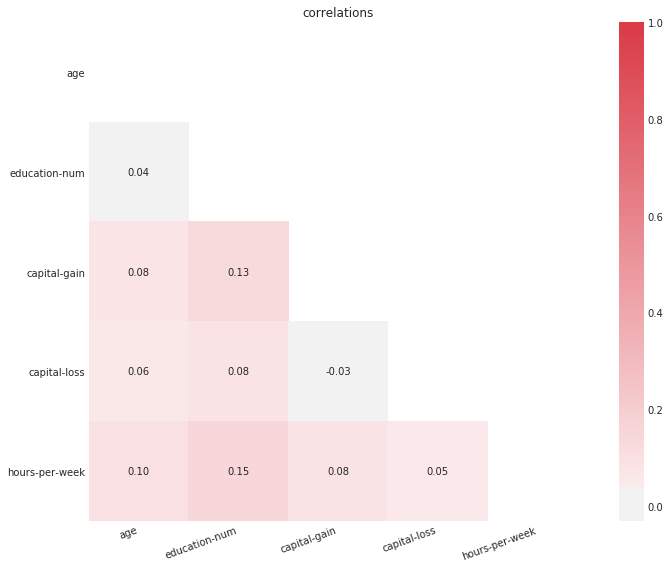

In [7]:
explore.plot_correlation_heatmap()

In [8]:
country_values = explore.dataset['native-country'].value_counts()
country_values = pd.DataFrame(country_values)
country_values['lookup'] = country_values.index.values
country_values.replace({'lookup': 
                        {'South': 'Korea, Rep.', 
                         'Hong':'Hong Kong SAR, China',
                         'England': 'United Kingdom',
                         'Columbia': 'Colombia',
                         'Iran': 'Iran, Islamic Rep.',
                         #'Taiwan': 'unknown',
                         'Trinadad&Tobago': 'Trinidad and Tobago',
                         'Holand-Netherlands': 'Netherlands',
                         'Scotland': 'United Kingdom',
                        }
                                }, inplace=True)
#country_values

In [9]:
gdp_per_capita = pd.read_csv('gdp_per_capita.csv')

In [11]:
country_values['gdp_per_capita'] = [gdp_per_capita[gdp_per_capita['Country Name'] ==  x.replace('-', ' ')].GDP_PER_CAPITA.iloc[0] if x.replace('-', ' ') in gdp_per_capita['Country Name'].values else np.nan for x in country_values['lookup'].values]

In [12]:
yugoslavia = ['Serbia', 'Montenegro', 'Slovenia', 'Croatia', 'Macedonia, FYR', 'Kosovo']
gdps_per_capita_yugo = [gdp_per_capita[gdp_per_capita['Country Name'] == x].GDP_PER_CAPITA.iloc[0] for x in yugoslavia]
mean_gdp_per_capita_yugo = np.mean(gdps_per_capita_yugo)
mean_gdp_per_capita_yugo

19995.586656386367

In [13]:
country_values.loc[country_values['lookup'] == 'Yugoslavia', 'gdp_per_capita'] = mean_gdp_per_capita_yugo

In [14]:
country_values.loc[country_values['lookup'] == 'Taiwan', 'gdp_per_capita'] = 8342.804479  # Philippines

In [15]:
country_values.gdp_per_capita.fillna(country_values.gdp_per_capita.quantile(q=.25), inplace=True)
assert not country_values.gdp_per_capita.isna().any()
country_values

native-country                      lookup  gdp_per_capita
United-States               41292           United-States               59531.661964  
Mexico                      903             Mexico                      18258.096211  
Philippines                 283             Philippines                 8342.804479   
Germany                     193             Germany                     50638.890964  
Puerto-Rico                 175             Puerto-Rico                 8342.804479   
Canada                      163             Canada                      46704.894722  
El-Salvador                 147             El-Salvador                 8006.059219   
India                       147             India                       7055.554830   
Cuba                        133             Cuba                        8342.804479   
England                     119             United Kingdom              43268.783556  
China                       113             China                       16806.741860  
Jamaica                     103             Jamaica                     8995.350211   
South                       101             Korea, Rep.                 38335.270479  
Italy                       100             Italy                       39426.940797  
Dominican-Republic          97              Dominican-Republic          16029.623707  
Japan                       89              Japan                       43278.989328  
Guatemala                   86              Guatemala                   8150.262204   
Vietnam                     83              Vietnam                     6775.832191   
Columbia                    82              Colombia                    14552.008561  
Poland                      81              Poland                      29026.166421  
Haiti                       69              Haiti                       1814.943236   
Portugal                    62              Portugal                    31672.713087  
Iran                        56              Iran, Islamic Rep.          20949.943999  
Taiwan                      55              Taiwan                      8342.804479   
Greece                      49              Greece                      27601.904924  
Nicaragua                   48              Nicaragua                   5842.171881   
Peru                        45              Peru                        13434.125605  
Ecuador                     43              Ecuador                     11617.428854  
Ireland                     36              Ireland                     75648.232849  
France                      36              France                      42850.386280  
Thailand                    29              Thailand                    17870.518102  
Hong                        28              Hong Kong SAR, China        61540.158311  
Cambodia                    26              Cambodia                    4001.756778   
Trinadad&Tobago             26              Trinidad and Tobago         31577.672995  
Yugoslavia                  23              Yugoslavia                  19995.586656  
Outlying-US(Guam-USVI-etc)  22              Outlying-US(Guam-USVI-etc)  8342.804479   
Laos                        21              Laos                        8342.804479   
Scotland                    20              United Kingdom              43268.783556  
Honduras                    19              Honduras                    4986.231360   
Hungary                     18              Hungary                     28107.891801  
Holand-Netherlands          1               Netherlands                 52503.268269

In [16]:
explore.dataset['gdp_per_capita']=[country_values[country_values.index == x].gdp_per_capita.iloc[0] for x in explore.dataset['native-country']]

In [17]:
explore.dataset.head(10)

age         workclass education_level  education-num         marital-status         occupation   relationship   race     sex  capital-gain  capital-loss  hours-per-week native-country income  gdp_per_capita
0  39   State-gov         Bachelors       13.0           Never-married          Adm-clerical       Not-in-family  White  Male    2174.0        0.0           40.0            United-States  <=50K  59531.661964  
1  50   Self-emp-not-inc  Bachelors       13.0           Married-civ-spouse     Exec-managerial    Husband        White  Male    0.0           0.0           13.0            United-States  <=50K  59531.661964  
2  38   Private           HS-grad         9.0            Divorced               Handlers-cleaners  Not-in-family  White  Male    0.0           0.0           40.0            United-States  <=50K  59531.661964  
3  53   Private           11th            7.0            Married-civ-spouse     Handlers-cleaners  Husband        Black  Male    0.0           0.0           40.0            United-States  <=50K  59531.661964  
4  28   Private           Bachelors       13.0           Married-civ-spouse     Prof-specialty     Wife           Black  Female  0.0           0.0           40.0            Cuba           <=50K  8342.804479   
5  37   Private           Masters         14.0           Married-civ-spouse     Exec-managerial    Wife           White  Female  0.0           0.0           40.0            United-States  <=50K  59531.661964  
6  49   Private           9th             5.0            Married-spouse-absent  Other-service      Not-in-family  Black  Female  0.0           0.0           16.0            Jamaica        <=50K  8995.350211   
7  52   Self-emp-not-inc  HS-grad         9.0            Married-civ-spouse     Exec-managerial    Husband        White  Male    0.0           0.0           45.0            United-States  >50K   59531.661964  
8  31   Private           Masters         14.0           Never-married          Prof-specialty     Not-in-family  White  Female  14084.0       0.0           50.0            United-States  >50K   59531.661964  
9  42   Private           Bachelors       13.0           Married-civ-spouse     Exec-managerial    Husband        White  Male    5178.0        0.0           40.0            United-States  >50K   59531.661964

In [18]:
# NOTE: since I will be cross-validating transformations e.g. GridSearchCV, it typically won't work to
# one-hot-encode during cross-validation because the holdout fold will tend to have categoric values that
# weren't found in the training folds, and therefore will break during transformation because it will encode
# a value (i.e. add a column) that didn't exist in the training folds.
# So, for this, we need to fit ALL data. Then, below if we have new data e.g. Kaggle, we have to apply
# the same pipeline (i.e.  cat_encoding_pipeline.transform()
# TODO: this breaks though if there are any categorical features with missing values in the final test/Kaggle set
one_hot_transformer = oo.DummyEncodeTransformer(encoding=oo.CategoricalEncoding.ONE_HOT)
transformed_data = one_hot_transformer.fit_transform(explore.dataset.drop(columns=[target_variable] + ['native-country']))
transformed_data[target_variable] = explore.dataset[target_variable]

In [19]:
transformed_data.head(10)

age  education-num  capital-gain  capital-loss  hours-per-week  gdp_per_capita  workclass_Federal-gov  workclass_Local-gov  workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  education_level_10th  education_level_11th  education_level_12th  education_level_1st-4th  education_level_5th-6th  education_level_7th-8th  education_level_9th  education_level_Assoc-acdm  education_level_Assoc-voc  education_level_Bachelors  \
0  39   13.0           2174.0        0.0           40.0            59531.661964    0                      0                    0                  0                       0                           1                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          1                           
1  50   13.0           0.0           0.0           13.0            59531.661964    0                      0                    0                  0                       1                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          1                           
2  38   9.0            0.0           0.0           40.0            59531.661964    0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          0                           
3  53   7.0            0.0           0.0           40.0            59531.661964    0                      0                    1                  0                       0                           0                    0                      0                     1                     0                     0                        0                        0                        0                    0                           0                          0                           
4  28   13.0           0.0           0.0           40.0            8342.804479     0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          1                           
5  37   14.0           0.0           0.0           40.0            59531.661964    0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          0                           
6  49   5.0            0.0           0.0           16.0            8995.350211     0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        1                    0                           0                          0                           
7  52   9.0            0.0           0.0           45.0            59531.661964    0               

In [20]:
assert transformed_data.isna().sum().sum() == 0

# Transformations & Transformation Tuning Parameters

define the transformations we want to do, some transformations will have parameters (e.g. base of log tranform (or no transform), type of scaling, whether or not to add column combinations (e.g. age * hours-per-week)

Below is the pipeline for captail-gain/lost. 

We want to tune whether or not we should log transform. We need to do this after imputing but before scaling, so it needs to be it's own pipeline.

In [21]:
cap_gain_loss_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['capital-gain', 'capital-loss'])),
        #('imputer', Imputer()),
        # tune Log trasformation base (or no transformation)
        ('custom_transform', CustomLogTransform(base=math.e)),
        # tune "net gain" (have to do it after log transform)
        ('custom_cap_gain_minus_loss', CombineCapitalGainLossTransform(combine=True)),
        # tune MinMax vs StandardScaler
        ('custom_scaler', ChooserTransform(base_transformer=StandardScaler())),
    ])

Below is the pipeline for the rest of numeric features:

In [22]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['age', 'education-num', 'hours-per-week', 'gdp_per_capita'])),
        #('imputer', Imputer()),
        # tune age * hours-per-week; update: tuned -chose not to include
        ('combine_agehours', CombineAgeHoursTransform()),
        # tune MinMax vs StandardScaler; update: tuned - chose MinMax
        ('custom_scaler', ChooserTransform(base_transformer=StandardScaler())),
    ])

Pipeline that simply gets the categorical/encoded columns from the previous transformation (which used `oo-learning`)

In [23]:
append_categoricals = Pipeline([
        ('append_cats', DataFrameSelector(attribute_names=one_hot_transformer.encoded_columns))  # already encoded
    ])

Below is the pipeline for combining all of the other pipelines

In [24]:
# combine pipelines
transformations_pipeline = FeatureUnion(transformer_list=[
        ("cap_gain_loss_pipeline", cap_gain_loss_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", append_categoricals),
    ])

In [25]:
test_transformations = transformations_pipeline.fit_transform(transformed_data)

In [26]:
pd.DataFrame(test_transformations).head(10)

0         1         2         3         4         5         6         7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64
0  2.815336 -0.222752  2.412200  0.034201  1.128753 -0.078120 -0.046799  0.284592  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
1 -0.300328 -0.222752 -0.127317  0.866417  1.128753 -2.326738 -1.289722  0.284592  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
2 -0.300328 -0.222752 -0.127317 -0.041455 -0.438122 -0.078120 -0.101433  0.284592  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
3 -0.300328 -0.222752 -0.127317  1.093385 -1.221559 -0.078120  0.718077  0.284592  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
4 -0.300328 -0.222752 -0.127317 -0.798015  1.128753 -0.078120 -0.647773 -4.086648  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
5 -0.300328 -0.222752 -0.127317 -0.117111  1.520471 -0.078120 -0.156067  0.284592  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
6 -0.300328 -0.222752 -0.127317  0.790761 -2.004996 -2.076892 -1.106698 -4.030924  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
7 -0.300328 -0.222752 -0.127317  1.017729 -0.438122  0.338291  1.018564  0.284592  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
8  3.572717 -0.222752  3.029527 -0.571047  1.520471  0.754701 -0.060457  0.284592  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
9  3.167082 -0.222752  2.698902  0.261169  1.128753 -0.078120  0.117103  0.284592  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [27]:
transformed_data.head(10)

age  education-num  capital-gain  capital-loss  hours-per-week  gdp_per_capita  workclass_Federal-gov  workclass_Local-gov  workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  education_level_10th  education_level_11th  education_level_12th  education_level_1st-4th  education_level_5th-6th  education_level_7th-8th  education_level_9th  education_level_Assoc-acdm  education_level_Assoc-voc  education_level_Bachelors  \
0  39   13.0           2174.0        0.0           40.0            59531.661964    0                      0                    0                  0                       0                           1                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          1                           
1  50   13.0           0.0           0.0           13.0            59531.661964    0                      0                    0                  0                       1                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          1                           
2  38   9.0            0.0           0.0           40.0            59531.661964    0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          0                           
3  53   7.0            0.0           0.0           40.0            59531.661964    0                      0                    1                  0                       0                           0                    0                      0                     1                     0                     0                        0                        0                        0                    0                           0                          0                           
4  28   13.0           0.0           0.0           40.0            8342.804479     0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          1                           
5  37   14.0           0.0           0.0           40.0            59531.661964    0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        0                    0                           0                          0                           
6  49   5.0            0.0           0.0           16.0            8995.350211     0                      0                    1                  0                       0                           0                    0                      0                     0                     0                     0                        0                        0                        1                    0                           0                          0                           
7  52   9.0            0.0           0.0           45.0            59531.661964    0               

Choose the transformations to tune, below:

In [28]:
from scipy.stats import randint, uniform, expon

(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.2036593 , 0.28227106, 0.36088283, 0.4394946 , 0.51810636,
        0.59671813, 0.6753299 , 0.75394166, 0.83255343, 0.9111652 ,
        0.98977696]),
 <a list of 10 Patch objects>)

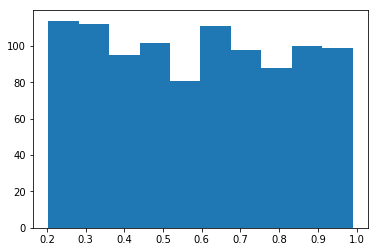

In [29]:
np.random.seed(42)
s = uniform(.2, .79).rvs(size=1000)
plt.hist(s)

In [30]:
min(s)

0.20365929817363626

In [31]:
max(s)

0.9897769618960433

(array([111., 105., 104.,  95.,  84., 112.,  98.,  89.,  83., 119.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <a list of 10 Patch objects>)

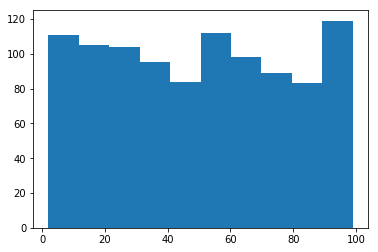

In [32]:
np.random.seed(42)
s = randint(2, 100).rvs(size=1000)
plt.hist(s)

In [33]:
min(s)

2

In [34]:
max(s)

99

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
                                                                 max_depth=5,
                                                                 min_samples_split=500,
                                                                 min_samples_leaf=50,
                                                                 max_features=10,
                                                                ),
                                    n_estimators=100,
                                    learning_rate=0.1,
                                    random_state=42)

In [36]:
model_param_dict = {
          'model__n_estimators': randint(100, 4000),
          'model__base_estimator__max_features': uniform(.2, .79),
          'model__base_estimator__max_depth': randint(2, 100),
          'model__base_estimator__min_samples_split': uniform(0.001, 0.98),
          'model__base_estimator__min_samples_leaf': uniform(0.001, 0.49),          
        }

In [37]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    #('pca_chooser', ChooserTransform()),
    #('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('model', model)
])

Tuning strategy according to https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [38]:
# actual hyper-parameters/options to tune for transformations.
transformation_parameters = {
         #'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],  # tune strategy
         #'pca_chooser__base_transformer': [PCA(n_components=0.95, random_state=42), None],  # PCA vs not
         'preparation__cap_gain_loss_pipeline__custom_transform__base': [None, math.e],  # Log transform (base e) or not
         'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': [True, False],
#         'preparation__cap_gain_loss_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],
         'preparation__num_pipeline__combine_agehours__combine': [True, False],
 #        'preparation__num_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],


    }

In [39]:
# def binary_roc_auc(y_true, y_score):
#     return roc_auc_score(y_true=y_true,
#                          # binary makes it so it converts the "scores" to predictions
#                          y_score=[1 if x > 0.5 else 0 for x in y_score])

scorer = make_scorer(roc_auc_score, greater_is_better=True)

In [40]:
y =  transformed_data[target_variable].apply(lambda x: 1 if x == positive_class else 0)

In [41]:
transformed_data[target_variable].values[0:10]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K',
       '>50K', '>50K', '>50K'], dtype=object)

In [42]:
y[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

In [43]:
param_grid = {**transformation_parameters, **model_param_dict}
param_grid

{'preparation__cap_gain_loss_pipeline__custom_transform__base': [None,
  2.718281828459045],
 'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': [True,
  False],
 'preparation__num_pipeline__combine_agehours__combine': [True, False],
 'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbe90d4bc50>,
 'model__base_estimator__max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbe90d42320>,
 'model__base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbe90d31cc0>,
 'model__base_estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbe90d31d30>,
 'model__base_estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbe90d31c18>}

In [44]:
print('Starting....')
time_start = time.time()
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=full_pipeline,
                                 param_distributions=param_grid,
                                 n_iter=500,
                                 cv=RepeatedKFold(n_splits=5, n_repeats=1),
                                 scoring=scorer,
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=2)
grid_search.fit(transformed_data.drop(columns=target_variable), y)
time_end = time.time()

Starting....
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] model__base_estimator__max_depth=96, model__base_estimator__max_features=0.24396625659201054, model__base_estimator__min_samples_leaf=0.413733877296109, model__base_estimator__min_samples_split=0.05160276831702258, model__n_estimators=2690, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV] model__base_estimator__max_depth=96, model__base_estimator__max_features=0.24396625659201054, model__base_estimator__min_samples_leaf=0.413733877296109, model__base_estimator__min_samples_split=0.05160276831702258, model__n_estimators=2690, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV] model__base_es

[CV]  model__base_estimator__max_depth=25, model__base_estimator__max_features=0.2885107327127614, model__base_estimator__min_samples_leaf=0.1959492435324134, model__base_estimator__min_samples_split=0.9510810246098614, model__n_estimators=103, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   5.0s
[CV] model__base_estimator__max_depth=52, model__base_estimator__max_features=0.8624802213750735, model__base_estimator__min_samples_leaf=0.10148800447323496, model__base_estimator__min_samples_split=0.9496341851741495, model__n_estimators=2983, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=25, model__base_estim

[CV]  model__base_estimator__max_depth=96, model__base_estimator__max_features=0.24396625659201054, model__base_estimator__min_samples_leaf=0.413733877296109, model__base_estimator__min_samples_split=0.05160276831702258, model__n_estimators=2690, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  59.5s
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.3915036886079134, model__base_estimator__min_samples_leaf=0.057270044122209735, model__base_estimator__min_samples_split=0.5994076415927999, model__n_estimators=419, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=96, model__base_estimator__max_features=0.

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min


[CV]  model__base_estimator__max_depth=21, model__base_estimator__max_features=0.3915036886079134, model__base_estimator__min_samples_leaf=0.057270044122209735, model__base_estimator__min_samples_split=0.5994076415927999, model__n_estimators=419, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  18.0s
[CV] model__base_estimator__max_depth=12, model__base_estimator__max_features=0.9362913303829781, model__base_estimator__min_samples_leaf=0.158114674158162, model__base_estimator__min_samples_split=0.5830054356067408, model__n_estimators=1001, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=21, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_features=0.25006622667348655, model__base_estimator__min_samples_leaf=0.48608051387107315, model__base_estimator__min_samples_split=0.3169067680752285, model__n_estimators=3813, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__base_estimator__max_depth=74, model__base_estimator__max_features=0.8005800093128523, model__base_estimator__min_samples_leaf=0.2928629828978437, model__base_estimator__min_samples_split=0.46314466477915517, model__n_estimators=2138, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=74, model__base_estimator__max_features=0.8005800093128523, model__base_estimator__min_samples_leaf=0.2928629828978437, model__base_estimator__min_samples_split=0.46314466477915517, model__n_estimators=2138, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.3min
[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.3431741222708715, model__base_estimator__min_samples_leaf=0.033583171009720976, model__base_estimator__min_samples_split=0.7272982363042578, model__n_estimators=3065, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=74, model__base_es

[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_features=0.8720746934129993, model__base_estimator__min_samples_leaf=0.36652751751887186, model__base_estimator__min_samples_split=0.4013479270771986, model__n_estimators=2008, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.2min
[CV] model__base_estimator__max_depth=84, model__base_estimator__max_features=0.7255058043499982, model__base_estimator__min_samples_leaf=0.25730205813686846, model__base_estimator__min_samples_split=0.3526538744410324, model__n_estimators=1872, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_features=0.8

[CV]  model__base_estimator__max_depth=84, model__base_estimator__max_features=0.7255058043499982, model__base_estimator__min_samples_leaf=0.25730205813686846, model__base_estimator__min_samples_split=0.3526538744410324, model__n_estimators=1872, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__base_estimator__max_depth=64, model__base_estimator__max_features=0.5971491081730586, model__base_estimator__min_samples_leaf=0.11478422062194048, model__base_estimator__min_samples_split=0.8825830818090771, model__n_estimators=602, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_features=0.3431741222708715, model__base_estimator__min_samples_leaf=0.033583171009720976, model__base_estimator__min_samples_split=0.7272982363042578, model__n_estimators=3065, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 6.1min
[CV] model__base_estimator__max_depth=52, model__base_estimator__max_features=0.6288509553845931, model__base_estimator__min_samples_leaf=0.21244879013685689, model__base_estimator__min_samples_split=0.3271594701942346, model__n_estimators=1302, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=64, model__base_

[CV]  model__base_estimator__max_depth=16, model__base_estimator__max_features=0.8941170011450164, model__base_estimator__min_samples_leaf=0.24375757693794317, model__base_estimator__min_samples_split=0.7276316929162645, model__n_estimators=1022, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  42.2s
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.4462604335584831, model__base_estimator__min_samples_leaf=0.12275967850908821, model__base_estimator__min_samples_split=0.7300673667212234, model__n_estimators=1377, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=16, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_features=0.557039395026241, model__base_estimator__min_samples_leaf=0.3507534028791097, model__base_estimator__min_samples_split=0.8826740963863297, model__n_estimators=3808, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.1min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.6771267189372849, model__base_estimator__min_samples_leaf=0.24712129025663976, model__base_estimator__min_samples_split=0.53006342437058, model__n_estimators=3328, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_feat

[CV]  model__base_estimator__max_depth=11, model__base_estimator__max_features=0.5902453748333816, model__base_estimator__min_samples_leaf=0.3707712930114571, model__base_estimator__min_samples_split=0.10185771012926212, model__n_estimators=2032, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.3min
[CV] model__base_estimator__max_depth=70, model__base_estimator__max_features=0.853171073969172, model__base_estimator__min_samples_leaf=0.4709466493363736, model__base_estimator__min_samples_split=0.3366737720349725, model__n_estimators=3305, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.7688

[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.7688288638713987, model__base_estimator__min_samples_leaf=0.3151623401137957, model__base_estimator__min_samples_split=0.681069475577758, model__n_estimators=3463, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.1min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.668440695154469, model__base_estimator__min_samples_leaf=0.051084205470347796, model__base_estimator__min_samples_split=0.9013755118155315, model__n_estimators=3304, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_features=0.853

[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_features=0.853171073969172, model__base_estimator__min_samples_leaf=0.4709466493363736, model__base_estimator__min_samples_split=0.3366737720349725, model__n_estimators=3305, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.5min
[CV] model__base_estimator__max_depth=93, model__base_estimator__max_features=0.4958039420791334, model__base_estimator__min_samples_leaf=0.03477155428993721, model__base_estimator__min_samples_split=0.0767746441790115, model__n_estimators=3633, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_features=0.853

[CV]  model__base_estimator__max_depth=91, model__base_estimator__max_features=0.9483538382933341, model__base_estimator__min_samples_leaf=0.07614218752687929, model__base_estimator__min_samples_split=0.5755052353764613, model__n_estimators=3105, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=10.4min
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.4623956659974018, model__base_estimator__min_samples_leaf=0.1536076893823642, model__base_estimator__min_samples_split=0.22384770845957036, model__n_estimators=2034, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=91, model__base_estimator__max_features=0.948

[CV]  model__base_estimator__max_depth=93, model__base_estimator__max_features=0.4958039420791334, model__base_estimator__min_samples_leaf=0.03477155428993721, model__base_estimator__min_samples_split=0.0767746441790115, model__n_estimators=3633, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 8.9min
[CV] model__base_estimator__max_depth=26, model__base_estimator__max_features=0.8821793310842361, model__base_estimator__min_samples_leaf=0.45325051358125756, model__base_estimator__min_samples_split=0.45738611987243694, model__n_estimators=574, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_features=0.4

[CV]  model__base_estimator__max_depth=44, model__base_estimator__max_features=0.2259488694923163, model__base_estimator__min_samples_leaf=0.4482472368107731, model__base_estimator__min_samples_split=0.24426191390200885, model__n_estimators=124, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   4.4s
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.44606380519487837, model__base_estimator__min_samples_leaf=0.38344289669758297, model__base_estimator__min_samples_split=0.27303542917682977, model__n_estimators=2813, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=44, model__base_e

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 37.4min


[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_features=0.8821793310842361, model__base_estimator__min_samples_leaf=0.45325051358125756, model__base_estimator__min_samples_split=0.45738611987243694, model__n_estimators=574, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  54.5s
[CV] model__base_estimator__max_depth=50, model__base_estimator__max_features=0.34064841382710365, model__base_estimator__min_samples_leaf=0.47192445556003304, model__base_estimator__min_samples_split=0.1466894731980507, model__n_estimators=3801, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=26, model__base_estimator__max

[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_features=0.44606380519487837, model__base_estimator__min_samples_leaf=0.38344289669758297, model__base_estimator__min_samples_split=0.27303542917682977, model__n_estimators=2813, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.8min
[CV] model__base_estimator__max_depth=62, model__base_estimator__max_features=0.34572566842089636, model__base_estimator__min_samples_leaf=0.14780199676557376, model__base_estimator__min_samples_split=0.3047381877432387, model__n_estimators=1089, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=89, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_features=0.34064841382710365, model__base_estimator__min_samples_leaf=0.47192445556003304, model__base_estimator__min_samples_split=0.1466894731980507, model__n_estimators=3801, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.9min
[CV] model__base_estimator__max_depth=41, model__base_estimator__max_features=0.6640883473449187, model__base_estimator__min_samples_leaf=0.14508189281827605, model__base_estimator__min_samples_split=0.7007780157940317, model__n_estimators=3157, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=62, model__base_

[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_features=0.6640883473449187, model__base_estimator__min_samples_leaf=0.14508189281827605, model__base_estimator__min_samples_split=0.7007780157940317, model__n_estimators=3157, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=33, model__base_estimator__max_features=0.4151184652290366, model__base_estimator__min_samples_leaf=0.4407409008112533, model__base_estimator__min_samples_split=0.5170468973261079, model__n_estimators=2234, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=41, model__base_es

[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.4151184652290366, model__base_estimator__min_samples_leaf=0.4407409008112533, model__base_estimator__min_samples_split=0.5170468973261079, model__n_estimators=2234, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.9min
[CV] model__base_estimator__max_depth=73, model__base_estimator__max_features=0.28224577976781334, model__base_estimator__min_samples_leaf=0.39295888183286276, model__base_estimator__min_samples_split=0.17597376881324694, model__n_estimators=3780, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=51, model__base_estimator__max_features=0.8849250704091036, model__base_estimator__min_samples_leaf=0.20091240272877392, model__base_estimator__min_samples_split=0.5416881433541529, model__n_estimators=1958, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.8min
[CV] model__base_estimator__max_depth=38, model__base_estimator__max_features=0.31145466053439375, model__base_estimator__min_samples_leaf=0.20013223105402578, model__base_estimator__min_samples_split=0.31851025988466364, model__n_estimators=2101, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__max

[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.6421158617334921, model__base_estimator__min_samples_leaf=0.07706772050604913, model__base_estimator__min_samples_split=0.1792895678853657, model__n_estimators=3072, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=13.9min
[CV] model__base_estimator__max_depth=34, model__base_estimator__max_features=0.3642301415653616, model__base_estimator__min_samples_leaf=0.01400077989817166, model__base_estimator__min_samples_split=0.17880672638800135, model__n_estimators=1671, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=13, model__base_estimator__max_features=0.8562170601865473, model__base_estimator__min_samples_leaf=0.17014415099182503, model__base_estimator__min_samples_split=0.7593578327373135, model__n_estimators=1004, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  44.3s
[CV] model__base_estimator__max_depth=13, model__base_estimator__max_features=0.8562170601865473, model__base_estimator__min_samples_leaf=0.17014415099182503, model__base_estimator__min_samples_split=0.7593578327373135, model__n_estimators=1004, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=13, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=34, model__base_estimator__max_features=0.3642301415653616, model__base_estimator__min_samples_leaf=0.01400077989817166, model__base_estimator__min_samples_split=0.17880672638800135, model__n_estimators=1671, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 8.9min
[CV] model__base_estimator__max_depth=97, model__base_estimator__max_features=0.5359186685306945, model__base_estimator__min_samples_leaf=0.012009961076857523, model__base_estimator__min_samples_split=0.26430381219724713, model__n_estimators=2699, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=3, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=74, model__base_estimator__max_features=0.3100912985175311, model__base_estimator__min_samples_leaf=0.4101158160316566, model__base_estimator__min_samples_split=0.9657141370894811, model__n_estimators=541, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  19.8s
[CV] model__base_estimator__max_depth=88, model__base_estimator__max_features=0.7397152465919303, model__base_estimator__min_samples_leaf=0.4040660991967202, model__base_estimator__min_samples_split=0.5200684450819795, model__n_estimators=2189, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=74, model__base_estimator__max_features=0.3100

[CV]  model__base_estimator__max_depth=87, model__base_estimator__max_features=0.8160094320825444, model__base_estimator__min_samples_leaf=0.05697658370099445, model__base_estimator__min_samples_split=0.5554610875672292, model__n_estimators=2206, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.6min
[CV] model__base_estimator__max_depth=86, model__base_estimator__max_features=0.408310204081347, model__base_estimator__min_samples_leaf=0.1315842127517323, model__base_estimator__min_samples_split=0.7185408868898812, model__n_estimators=709, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=88, model__base_estimator__max_features=0.7397

[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_features=0.6378006219874768, model__base_estimator__min_samples_leaf=0.32019599029241347, model__base_estimator__min_samples_split=0.8141469676330576, model__n_estimators=1722, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=54, model__base_estimator__max_features=0.3385433101125252, model__base_estimator__min_samples_leaf=0.4490618535032303, model__base_estimator__min_samples_split=0.41139511439423165, model__n_estimators=3647, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=35, model__base_e

[CV]  model__base_estimator__max_depth=54, model__base_estimator__max_features=0.3385433101125252, model__base_estimator__min_samples_leaf=0.4490618535032303, model__base_estimator__min_samples_split=0.41139511439423165, model__n_estimators=3647, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.5075435350931614, model__base_estimator__min_samples_leaf=0.14245993101764293, model__base_estimator__min_samples_split=0.34955926213565014, model__n_estimators=1236, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=54, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_features=0.5075435350931614, model__base_estimator__min_samples_leaf=0.14245993101764293, model__base_estimator__min_samples_split=0.34955926213565014, model__n_estimators=1236, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.3min
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.6264757953374729, model__base_estimator__min_samples_leaf=0.08038680016687647, model__base_estimator__min_samples_split=0.8256990671038426, model__n_estimators=3105, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_features=0.50

[CV]  model__base_estimator__max_depth=37, model__base_estimator__max_features=0.6264757953374729, model__base_estimator__min_samples_leaf=0.08038680016687647, model__base_estimator__min_samples_split=0.8256990671038426, model__n_estimators=3105, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.1min
[CV] model__base_estimator__max_depth=62, model__base_estimator__max_features=0.7438378931779115, model__base_estimator__min_samples_leaf=0.21406539591583565, model__base_estimator__min_samples_split=0.24247399257432467, model__n_estimators=230, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=62, model__base_estimator__max_features=0.74

[CV]  model__base_estimator__max_depth=99, model__base_estimator__max_features=0.6924327152149428, model__base_estimator__min_samples_leaf=0.2333762812631811, model__base_estimator__min_samples_split=0.33849605740334854, model__n_estimators=2443, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.7min
[CV] model__base_estimator__max_depth=50, model__base_estimator__max_features=0.3080867184259795, model__base_estimator__min_samples_leaf=0.4666163033721932, model__base_estimator__min_samples_split=0.43808565749879663, model__n_estimators=3986, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=99, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_features=0.7991300070170884, model__base_estimator__min_samples_leaf=0.31408519881378827, model__base_estimator__min_samples_split=0.7448551286280728, model__n_estimators=1608, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.0min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.7991300070170884, model__base_estimator__min_samples_leaf=0.31408519881378827, model__base_estimator__min_samples_split=0.7448551286280728, model__n_estimators=1608, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=50, model__base_

[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_features=0.3972377269987569, model__base_estimator__min_samples_leaf=0.24081823218513884, model__base_estimator__min_samples_split=0.21778525298321016, model__n_estimators=588, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  39.0s
[CV] model__base_estimator__max_depth=33, model__base_estimator__max_features=0.7574043862873938, model__base_estimator__min_samples_leaf=0.45437167553367624, model__base_estimator__min_samples_split=0.17796383822478687, model__n_estimators=3128, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=73, model__base_es

[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.7574043862873938, model__base_estimator__min_samples_leaf=0.45437167553367624, model__base_estimator__min_samples_split=0.17796383822478687, model__n_estimators=3128, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.2min
[CV] model__base_estimator__max_depth=83, model__base_estimator__max_features=0.7886009930149742, model__base_estimator__min_samples_leaf=0.027892481176772715, model__base_estimator__min_samples_split=0.44704081133543294, model__n_estimators=1566, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=33, model__base_estimator__m

[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_features=0.7886009930149742, model__base_estimator__min_samples_leaf=0.027892481176772715, model__base_estimator__min_samples_split=0.44704081133543294, model__n_estimators=1566, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=10.5min
[CV] model__base_estimator__max_depth=41, model__base_estimator__max_features=0.5484154077810477, model__base_estimator__min_samples_leaf=0.19919787034410685, model__base_estimator__min_samples_split=0.5619792042447964, model__n_estimators=2644, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_features=0

[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_features=0.5484154077810477, model__base_estimator__min_samples_leaf=0.19919787034410685, model__base_estimator__min_samples_split=0.5619792042447964, model__n_estimators=2644, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.6min
[CV] model__base_estimator__max_depth=43, model__base_estimator__max_features=0.982369637540004, model__base_estimator__min_samples_leaf=0.001116386552183444, model__base_estimator__min_samples_split=0.182763451385188, model__n_estimators=1397, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=15, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_features=0.2074934925665135, model__base_estimator__min_samples_leaf=0.02681507962884201, model__base_estimator__min_samples_split=0.08777254240134579, model__n_estimators=417, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.1min
[CV] model__base_estimator__max_depth=40, model__base_estimator__max_features=0.2074934925665135, model__base_estimator__min_samples_leaf=0.02681507962884201, model__base_estimator__min_samples_split=0.08777254240134579, model__n_estimators=417, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=40, model__base_esti

[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_features=0.7784947276758696, model__base_estimator__min_samples_leaf=0.0026397174010598192, model__base_estimator__min_samples_split=0.4589645512068995, model__n_estimators=475, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__base_estimator__max_depth=6, model__base_estimator__max_features=0.7784947276758696, model__base_estimator__min_samples_leaf=0.0026397174010598192, model__base_estimator__min_samples_split=0.4589645512068995, model__n_estimators=475, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=6, model__base_e

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 121.3min


[CV]  model__base_estimator__max_depth=45, model__base_estimator__max_features=0.9644825166835984, model__base_estimator__min_samples_leaf=0.0035743710936086085, model__base_estimator__min_samples_split=0.10203187109346998, model__n_estimators=1736, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=41.8min
[CV] model__base_estimator__max_depth=19, model__base_estimator__max_features=0.38455012332942884, model__base_estimator__min_samples_leaf=0.021625662921817324, model__base_estimator__min_samples_split=0.018516456038745535, model__n_estimators=2098, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=45, model__base_estimator__max_feature

[CV]  model__base_estimator__max_depth=19, model__base_estimator__max_features=0.38455012332942884, model__base_estimator__min_samples_leaf=0.021625662921817324, model__base_estimator__min_samples_split=0.018516456038745535, model__n_estimators=2098, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=10.9min
[CV] model__base_estimator__max_depth=57, model__base_estimator__max_features=0.8985171927238873, model__base_estimator__min_samples_leaf=0.29539123875667705, model__base_estimator__min_samples_split=0.886649487831765, model__n_estimators=2373, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=19, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=5, model__base_estimator__max_features=0.3830206440929203, model__base_estimator__min_samples_leaf=0.4629385693262116, model__base_estimator__min_samples_split=0.6376537160125211, model__n_estimators=984, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  42.4s
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.2370868321467723, model__base_estimator__min_samples_leaf=0.18920439963071228, model__base_estimator__min_samples_split=0.03699729867808135, model__n_estimators=2653, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=5, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.2370868321467723, model__base_estimator__min_samples_leaf=0.18920439963071228, model__base_estimator__min_samples_split=0.03699729867808135, model__n_estimators=2653, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.6min
[CV] model__base_estimator__max_depth=62, model__base_estimator__max_features=0.40558436068170656, model__base_estimator__min_samples_leaf=0.2534714829142157, model__base_estimator__min_samples_split=0.482362614051254, model__n_estimators=3316, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=75, model__base_estimator__max

[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.2370868321467723, model__base_estimator__min_samples_leaf=0.18920439963071228, model__base_estimator__min_samples_split=0.03699729867808135, model__n_estimators=2653, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.7min
[CV] model__base_estimator__max_depth=14, model__base_estimator__max_features=0.3768159157098723, model__base_estimator__min_samples_leaf=0.26411746721777263, model__base_estimator__min_samples_split=0.5820811361448691, model__n_estimators=2033, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=6, model__base_est

[CV]  model__base_estimator__max_depth=62, model__base_estimator__max_features=0.40558436068170656, model__base_estimator__min_samples_leaf=0.2534714829142157, model__base_estimator__min_samples_split=0.482362614051254, model__n_estimators=3316, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__base_estimator__max_depth=10, model__base_estimator__max_features=0.4599505786421981, model__base_estimator__min_samples_leaf=0.45747884927630506, model__base_estimator__min_samples_split=0.7215084014329837, model__n_estimators=3397, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=57, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=39, model__base_estimator__max_features=0.4052054891706577, model__base_estimator__min_samples_leaf=0.35547585570740664, model__base_estimator__min_samples_split=0.4869582203771954, model__n_estimators=553, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  30.4s
[CV] model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9066391454647733, model__base_estimator__min_samples_leaf=0.4868229142210736, model__base_estimator__min_samples_split=0.06128668571445035, model__n_estimators=1424, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=39, model__base_est

[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9066391454647733, model__base_estimator__min_samples_leaf=0.4868229142210736, model__base_estimator__min_samples_split=0.06128668571445035, model__n_estimators=1424, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.3min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.8299665570694732, model__base_estimator__min_samples_leaf=0.3236413989826285, model__base_estimator__min_samples_split=0.8345700945123571, model__n_estimators=3742, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=10, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=59, model__base_estimator__max_features=0.6513419641164635, model__base_estimator__min_samples_leaf=0.3254348849522167, model__base_estimator__min_samples_split=0.5339033298374513, model__n_estimators=2096, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.8min
[CV] model__base_estimator__max_depth=46, model__base_estimator__max_features=0.8887563869187334, model__base_estimator__min_samples_leaf=0.015331168686933981, model__base_estimator__min_samples_split=0.8103004155534674, model__n_estimators=3565, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=59, model__base_estimator__max_features=0.65

[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_features=0.8299665570694732, model__base_estimator__min_samples_leaf=0.3236413989826285, model__base_estimator__min_samples_split=0.8345700945123571, model__n_estimators=3742, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.7min
[CV] model__base_estimator__max_depth=31, model__base_estimator__max_features=0.9178740343228007, model__base_estimator__min_samples_leaf=0.0015488546252536485, model__base_estimator__min_samples_split=0.5460581003389618, model__n_estimators=688, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=0.20716719967565272, model__base_estimator__min_samples_leaf=0.4021529160449225, model__base_estimator__min_samples_split=0.12687974373132754, model__n_estimators=2614, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  50.9s
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.20716719967565272, model__base_estimator__min_samples_leaf=0.4021529160449225, model__base_estimator__min_samples_split=0.12687974373132754, model__n_estimators=2614, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=

[CV]  model__base_estimator__max_depth=97, model__base_estimator__max_features=0.863695987165563, model__base_estimator__min_samples_leaf=0.19315409360814634, model__base_estimator__min_samples_split=0.17690737695535672, model__n_estimators=2184, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 5.8min
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.7434297206176426, model__base_estimator__min_samples_leaf=0.034240158961534234, model__base_estimator__min_samples_split=0.29594429560787994, model__n_estimators=1140, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=97, model__base_

[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.8887563869187334, model__base_estimator__min_samples_leaf=0.015331168686933981, model__base_estimator__min_samples_split=0.8103004155534674, model__n_estimators=3565, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=17.9min
[CV] model__base_estimator__max_depth=48, model__base_estimator__max_features=0.9654135056756963, model__base_estimator__min_samples_leaf=0.3683293975540331, model__base_estimator__min_samples_split=0.12848451532801933, model__n_estimators=2528, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.8

[CV]  model__base_estimator__max_depth=48, model__base_estimator__max_features=0.9654135056756963, model__base_estimator__min_samples_leaf=0.3683293975540331, model__base_estimator__min_samples_split=0.12848451532801933, model__n_estimators=2528, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.4min
[CV] model__base_estimator__max_depth=99, model__base_estimator__max_features=0.41616506636251605, model__base_estimator__min_samples_leaf=0.48959100507727843, model__base_estimator__min_samples_split=0.4186576761912535, model__n_estimators=2544, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=48, model__base_estimator__max_features=0.96

[CV]  model__base_estimator__max_depth=11, model__base_estimator__max_features=0.57412337186372, model__base_estimator__min_samples_leaf=0.029381025673811165, model__base_estimator__min_samples_split=0.07420052940269693, model__n_estimators=2357, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 6.4min
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.7480089583673761, model__base_estimator__min_samples_leaf=0.10917711026649259, model__base_estimator__min_samples_split=0.08173342470352585, model__n_estimators=1073, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=99, model__base_

[CV]  model__base_estimator__max_depth=28, model__base_estimator__max_features=0.8857629148005115, model__base_estimator__min_samples_leaf=0.47298596018566463, model__base_estimator__min_samples_split=0.03167626747256592, model__n_estimators=1088, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.7min
[CV] model__base_estimator__max_depth=60, model__base_estimator__max_features=0.9619711730934648, model__base_estimator__min_samples_leaf=0.3734460984346676, model__base_estimator__min_samples_split=0.43445278713329205, model__n_estimators=1630, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=28, model__base_estimator__max

[CV]  model__base_estimator__max_depth=60, model__base_estimator__max_features=0.9619711730934648, model__base_estimator__min_samples_leaf=0.3734460984346676, model__base_estimator__min_samples_split=0.43445278713329205, model__n_estimators=1630, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.5min
[CV] model__base_estimator__max_depth=16, model__base_estimator__max_features=0.572510643480985, model__base_estimator__min_samples_leaf=0.2671840748370795, model__base_estimator__min_samples_split=0.15706082351367917, model__n_estimators=1084, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=60, model__base_estimator__max_features=0.9619711730934648, model__base_estimator__min_samples_leaf=0.3734460984346676, model__base_estimator__min_samples_split=0.43445278713329205, model__n_estimators=1630, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.5min
[CV] model__base_estimator__max_depth=54, model__base_estimator__max_features=0.9203504676183298, model__base_estimator__min_samples_leaf=0.47508051917075106, model__base_estimator__min_samples_split=0.18274969718312126, model__n_estimators=626, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=16, model__base_es

[CV]  model__base_estimator__max_depth=72, model__base_estimator__max_features=0.29889677584001484, model__base_estimator__min_samples_leaf=0.33692699074219595, model__base_estimator__min_samples_split=0.42269977700147343, model__n_estimators=1801, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  41.9s
[CV] model__base_estimator__max_depth=64, model__base_estimator__max_features=0.7147003787737891, model__base_estimator__min_samples_leaf=0.1607034773365167, model__base_estimator__min_samples_split=0.57945866010791, model__n_estimators=683, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=72, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_features=0.809028257268801, model__base_estimator__min_samples_leaf=0.4149437817772749, model__base_estimator__min_samples_split=0.7468035111241389, model__n_estimators=2534, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__base_estimator__max_depth=82, model__base_estimator__max_features=0.2091802265273995, model__base_estimator__min_samples_leaf=0.03649897501933385, model__base_estimator__min_samples_split=0.38564368527855114, model__n_estimators=1489, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=64, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=52, model__base_estimator__max_features=0.28289484095035816, model__base_estimator__min_samples_leaf=0.11960205777263846, model__base_estimator__min_samples_split=0.9679293414018035, model__n_estimators=1795, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.1min
[CV] model__base_estimator__max_depth=52, model__base_estimator__max_features=0.28289484095035816, model__base_estimator__min_samples_leaf=0.11960205777263846, model__base_estimator__min_samples_split=0.9679293414018035, model__n_estimators=1795, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=82, model__base_

[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.7190172474759495, model__base_estimator__min_samples_leaf=0.3719590411294994, model__base_estimator__min_samples_split=0.9345956652779427, model__n_estimators=3596, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.0min
[CV] model__base_estimator__max_depth=98, model__base_estimator__max_features=0.26941453432441836, model__base_estimator__min_samples_leaf=0.17280719629249858, model__base_estimator__min_samples_split=0.033539046615539234, model__n_estimators=2263, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=33, model__base_estimator__m

[CV]  model__base_estimator__max_depth=52, model__base_estimator__max_features=0.28289484095035816, model__base_estimator__min_samples_leaf=0.11960205777263846, model__base_estimator__min_samples_split=0.9679293414018035, model__n_estimators=1795, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__base_estimator__max_depth=45, model__base_estimator__max_features=0.2826085938641762, model__base_estimator__min_samples_leaf=0.312850822276382, model__base_estimator__min_samples_split=0.6933462119571632, model__n_estimators=2025, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=52, model__base_esti

[CV]  model__base_estimator__max_depth=45, model__base_estimator__max_features=0.2826085938641762, model__base_estimator__min_samples_leaf=0.312850822276382, model__base_estimator__min_samples_split=0.6933462119571632, model__n_estimators=2025, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__base_estimator__max_depth=63, model__base_estimator__max_features=0.6836838088461148, model__base_estimator__min_samples_leaf=0.2383552393112799, model__base_estimator__min_samples_split=0.6486037159332657, model__n_estimators=307, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=45, model__base_estima

[CV]  model__base_estimator__max_depth=63, model__base_estimator__max_features=0.6836838088461148, model__base_estimator__min_samples_leaf=0.2383552393112799, model__base_estimator__min_samples_split=0.6486037159332657, model__n_estimators=307, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  13.0s
[CV] model__base_estimator__max_depth=23, model__base_estimator__max_features=0.5573314447694571, model__base_estimator__min_samples_leaf=0.31635307064629725, model__base_estimator__min_samples_split=0.5168746077173909, model__n_estimators=973, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=63, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=96, model__base_estimator__max_features=0.6276241048878457, model__base_estimator__min_samples_leaf=0.34843965453094905, model__base_estimator__min_samples_split=0.8545497412711639, model__n_estimators=1813, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  53.0s
[CV]  model__base_estimator__max_depth=23, model__base_estimator__max_features=0.5573314447694571, model__base_estimator__min_samples_leaf=0.31635307064629725, model__base_estimator__min_samples_split=0.5168746077173909, model__n_estimators=973, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  30.4s
[CV] model__base_estimator__max_depth=46, model__base_

[CV]  model__base_estimator__max_depth=36, model__base_estimator__max_features=0.37424328868863543, model__base_estimator__min_samples_leaf=0.20601589644714982, model__base_estimator__min_samples_split=0.20050671473539783, model__n_estimators=1002, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  39.0s
[CV] model__base_estimator__max_depth=36, model__base_estimator__max_features=0.37424328868863543, model__base_estimator__min_samples_leaf=0.20601589644714982, model__base_estimator__min_samples_split=0.20050671473539783, model__n_estimators=1002, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=36, model__base_estimator__max_feature

[CV]  model__base_estimator__max_depth=13, model__base_estimator__max_features=0.39521155486801574, model__base_estimator__min_samples_leaf=0.07917689325546229, model__base_estimator__min_samples_split=0.8553478952603576, model__n_estimators=2269, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.8min
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.5988274566954841, model__base_estimator__min_samples_leaf=0.2672172564480113, model__base_estimator__min_samples_split=0.5047159504525505, model__n_estimators=3788, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=13, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=19, model__base_estimator__max_features=0.7160777851974909, model__base_estimator__min_samples_leaf=0.16383416642400336, model__base_estimator__min_samples_split=0.5326290630049801, model__n_estimators=1182, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.5min
[CV] model__base_estimator__max_depth=59, model__base_estimator__max_features=0.9207670430371859, model__base_estimator__min_samples_leaf=0.10422447261277662, model__base_estimator__min_samples_split=0.6115072518922131, model__n_estimators=3723, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=86, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=27, model__base_estimator__max_features=0.76550172209885, model__base_estimator__min_samples_leaf=0.4464259351261641, model__base_estimator__min_samples_split=0.17708944669283713, model__n_estimators=1039, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  35.2s
[CV] model__base_estimator__max_depth=27, model__base_estimator__max_features=0.76550172209885, model__base_estimator__min_samples_leaf=0.4464259351261641, model__base_estimator__min_samples_split=0.17708944669283713, model__n_estimators=1039, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=27, model__base_esti

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.8749642237619675, model__base_estimator__min_samples_leaf=0.24221614965953706, model__base_estimator__min_samples_split=0.2432864529151135, model__n_estimators=1951, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.4min
[CV] model__base_estimator__max_depth=90, model__base_estimator__max_features=0.723470810416573, model__base_estimator__min_samples_leaf=0.047678138897766884, model__base_estimator__min_samples_split=0.6400807806198291, model__n_estimators=2140, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_features=0.45690015073750895, model__base_estimator__min_samples_leaf=0.3800018315864343, model__base_estimator__min_samples_split=0.12925618750398282, model__n_estimators=400, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  23.5s
[CV] model__base_estimator__max_depth=12, model__base_estimator__max_features=0.8981306390319945, model__base_estimator__min_samples_leaf=0.2175919431536002, model__base_estimator__min_samples_split=0.3252715757293885, model__n_estimators=1728, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_fea

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 200.7min


[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.723470810416573, model__base_estimator__min_samples_leaf=0.047678138897766884, model__base_estimator__min_samples_split=0.6400807806198291, model__n_estimators=2140, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 7.0min
[CV] model__base_estimator__max_depth=2, model__base_estimator__max_features=0.5550527298188528, model__base_estimator__min_samples_leaf=0.2890633418440896, model__base_estimator__min_samples_split=0.9306116877544051, model__n_estimators=2460, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=59, model__base_est

[CV]  model__base_estimator__max_depth=2, model__base_estimator__max_features=0.5550527298188528, model__base_estimator__min_samples_leaf=0.2890633418440896, model__base_estimator__min_samples_split=0.9306116877544051, model__n_estimators=2460, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__base_estimator__max_depth=45, model__base_estimator__max_features=0.5526312307449426, model__base_estimator__min_samples_leaf=0.42446592706034275, model__base_estimator__min_samples_split=0.5479774446019856, model__n_estimators=1374, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=2, model__base_esti

[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.22897042727749897, model__base_estimator__min_samples_leaf=0.36183698738216385, model__base_estimator__min_samples_split=0.651528437069369, model__n_estimators=2312, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__base_estimator__max_depth=79, model__base_estimator__max_features=0.24509861631055874, model__base_estimator__min_samples_leaf=0.2612730687205057, model__base_estimator__min_samples_split=0.9188735784490623, model__n_estimators=2944, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=45, model__base_estimator__max_features=0.552

[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.723470810416573, model__base_estimator__min_samples_leaf=0.047678138897766884, model__base_estimator__min_samples_split=0.6400807806198291, model__n_estimators=2140, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 7.1min
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.979437797137489, model__base_estimator__min_samples_leaf=0.4739081612536623, model__base_estimator__min_samples_split=0.005841181315721423, model__n_estimators=316, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=21, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.31339846601112037, model__base_estimator__min_samples_leaf=0.46151169804415243, model__base_estimator__min_samples_split=0.719240939974515, model__n_estimators=3179, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.0min
[CV] model__base_estimator__max_depth=46, model__base_estimator__max_features=0.31339846601112037, model__base_estimator__min_samples_leaf=0.46151169804415243, model__base_estimator__min_samples_split=0.719240939974515, model__n_estimators=3179, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.31

[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_features=0.3233694373858174, model__base_estimator__min_samples_leaf=0.11593503373406605, model__base_estimator__min_samples_split=0.945079896163991, model__n_estimators=1298, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.0min
[CV] model__base_estimator__max_depth=91, model__base_estimator__max_features=0.4956944460404362, model__base_estimator__min_samples_leaf=0.009582835522410495, model__base_estimator__min_samples_split=0.24026434461392676, model__n_estimators=3709, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_features=0.32

[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_features=0.5592444859507487, model__base_estimator__min_samples_leaf=0.2536420540038326, model__base_estimator__min_samples_split=0.48006964865178176, model__n_estimators=3599, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 5.2min
[CV] model__base_estimator__max_depth=15, model__base_estimator__max_features=0.5111528804667852, model__base_estimator__min_samples_leaf=0.3201041587503311, model__base_estimator__min_samples_split=0.1054611697018309, model__n_estimators=3391, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=40, model__base_es

[CV]  model__base_estimator__max_depth=15, model__base_estimator__max_features=0.5111528804667852, model__base_estimator__min_samples_leaf=0.3201041587503311, model__base_estimator__min_samples_split=0.1054611697018309, model__n_estimators=3391, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__base_estimator__max_depth=71, model__base_estimator__max_features=0.45130812735831444, model__base_estimator__min_samples_leaf=0.42555494708854624, model__base_estimator__min_samples_split=0.9744701986114559, model__n_estimators=2928, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=15, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=32, model__base_estimator__max_features=0.7833748753085479, model__base_estimator__min_samples_leaf=0.4314726250376605, model__base_estimator__min_samples_split=0.3970575152180123, model__n_estimators=593, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  40.7s
[CV] model__base_estimator__max_depth=71, model__base_estimator__max_features=0.912086763174871, model__base_estimator__min_samples_leaf=0.4311666679302505, model__base_estimator__min_samples_split=0.31185180243009064, model__n_estimators=1488, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=32, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=71, model__base_estimator__max_features=0.912086763174871, model__base_estimator__min_samples_leaf=0.4311666679302505, model__base_estimator__min_samples_split=0.31185180243009064, model__n_estimators=1488, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.6333147801046667, model__base_estimator__min_samples_leaf=0.2932778827428566, model__base_estimator__min_samples_split=0.535773150725564, model__n_estimators=2438, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=55, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=0.6333147801046667, model__base_estimator__min_samples_leaf=0.2932778827428566, model__base_estimator__min_samples_split=0.535773150725564, model__n_estimators=2438, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=27, model__base_estimator__max_features=0.9516680621361331, model__base_estimator__min_samples_leaf=0.41611200707256135, model__base_estimator__min_samples_split=0.8969517856324405, model__n_estimators=3392, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=91, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=12, model__base_estimator__max_features=0.6767243887712886, model__base_estimator__min_samples_leaf=0.32842427129195795, model__base_estimator__min_samples_split=0.6081005390894222, model__n_estimators=3089, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.3min
[CV] model__base_estimator__max_depth=71, model__base_estimator__max_features=0.7900318157473001, model__base_estimator__min_samples_leaf=0.35159054447864446, model__base_estimator__min_samples_split=0.5118094498356276, model__n_estimators=120, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=71, model__base_estimator__max_features=0.79003

[CV]  model__base_estimator__max_depth=27, model__base_estimator__max_features=0.9516680621361331, model__base_estimator__min_samples_leaf=0.41611200707256135, model__base_estimator__min_samples_split=0.8969517856324405, model__n_estimators=3392, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=81, model__base_estimator__max_features=0.7115050241821363, model__base_estimator__min_samples_leaf=0.4410349689854936, model__base_estimator__min_samples_split=0.23961265064477327, model__n_estimators=814, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=12, model__base_estimator__max_features=0.67

[CV]  model__base_estimator__max_depth=28, model__base_estimator__max_features=0.9343886431633714, model__base_estimator__min_samples_leaf=0.26180750453612966, model__base_estimator__min_samples_split=0.5703134121975417, model__n_estimators=205, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   9.5s
[CV] model__base_estimator__max_depth=28, model__base_estimator__max_features=0.9343886431633714, model__base_estimator__min_samples_leaf=0.26180750453612966, model__base_estimator__min_samples_split=0.5703134121975417, model__n_estimators=205, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=28, model__base_es

[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_features=0.5150699969085515, model__base_estimator__min_samples_leaf=0.2852844609213928, model__base_estimator__min_samples_split=0.5239304957923409, model__n_estimators=2930, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.7min
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.8318270653849771, model__base_estimator__min_samples_leaf=0.09144671347314616, model__base_estimator__min_samples_split=0.29037272343590387, model__n_estimators=3412, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=22, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=3, model__base_estimator__max_features=0.4153729605794917, model__base_estimator__min_samples_leaf=0.20363905974742225, model__base_estimator__min_samples_split=0.1204483714702086, model__n_estimators=3630, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.4min
[CV] model__base_estimator__max_depth=48, model__base_estimator__max_features=0.9516086403432591, model__base_estimator__min_samples_leaf=0.2957897918717023, model__base_estimator__min_samples_split=0.8038050822382544, model__n_estimators=2873, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=3, model__base_estimator__max_features=0.4153

[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.8318270653849771, model__base_estimator__min_samples_leaf=0.09144671347314616, model__base_estimator__min_samples_split=0.29037272343590387, model__n_estimators=3412, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 5.5min
[CV] model__base_estimator__max_depth=50, model__base_estimator__max_features=0.38712774158984087, model__base_estimator__min_samples_leaf=0.3834575024694923, model__base_estimator__min_samples_split=0.27030991483717337, model__n_estimators=2678, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=57, model__base_estimator__m

[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_features=0.38712774158984087, model__base_estimator__min_samples_leaf=0.3834575024694923, model__base_estimator__min_samples_split=0.27030991483717337, model__n_estimators=2678, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.839528680857069, model__base_estimator__min_samples_leaf=0.37666150624819894, model__base_estimator__min_samples_split=0.14770988859781858, model__n_estimators=1562, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=50, model__base_estimator__max

[CV]  model__base_estimator__max_depth=10, model__base_estimator__max_features=0.7108186716040594, model__base_estimator__min_samples_leaf=0.0866389869854148, model__base_estimator__min_samples_split=0.3545570687283878, model__n_estimators=2829, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.0min
[CV] model__base_estimator__max_depth=36, model__base_estimator__max_features=0.6796042885101368, model__base_estimator__min_samples_leaf=0.2688817322298943, model__base_estimator__min_samples_split=0.2283081541936559, model__n_estimators=2737, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.7470245595462521, model__base_estimator__min_samples_leaf=0.48671543691407226, model__base_estimator__min_samples_split=0.12682640366504272, model__n_estimators=3702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.9min
[CV] model__base_estimator__max_depth=42, model__base_estimator__max_features=0.7470245595462521, model__base_estimator__min_samples_leaf=0.48671543691407226, model__base_estimator__min_samples_split=0.12682640366504272, model__n_estimators=3702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=42, model__bas

[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.7470245595462521, model__base_estimator__min_samples_leaf=0.48671543691407226, model__base_estimator__min_samples_split=0.12682640366504272, model__n_estimators=3702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.0min
[CV] model__base_estimator__max_depth=74, model__base_estimator__max_features=0.45546353407126144, model__base_estimator__min_samples_leaf=0.11206163709122413, model__base_estimator__min_samples_split=0.3488963797152986, model__n_estimators=807, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=74, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=43, model__base_estimator__max_features=0.9153645859404425, model__base_estimator__min_samples_leaf=0.3795851364501974, model__base_estimator__min_samples_split=0.2605975382919987, model__n_estimators=1864, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.8min
[CV] model__base_estimator__max_depth=68, model__base_estimator__max_features=0.621036651375555, model__base_estimator__min_samples_leaf=0.15992353902653403, model__base_estimator__min_samples_split=0.32734187479703397, model__n_estimators=1253, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=43, model__base_esti

[CV]  model__base_estimator__max_depth=82, model__base_estimator__max_features=0.9864295876563631, model__base_estimator__min_samples_leaf=0.21971265208684465, model__base_estimator__min_samples_split=0.3278981584827564, model__n_estimators=761, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  43.9s
[CV] model__base_estimator__max_depth=82, model__base_estimator__max_features=0.9864295876563631, model__base_estimator__min_samples_leaf=0.21971265208684465, model__base_estimator__min_samples_split=0.3278981584827564, model__n_estimators=761, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=82, model__base_es

[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_features=0.33848932446255114, model__base_estimator__min_samples_leaf=0.3391023965021262, model__base_estimator__min_samples_split=0.19791501488587535, model__n_estimators=307, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   6.5s
[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.7973690298272444, model__base_estimator__min_samples_leaf=0.17131004687710122, model__base_estimator__min_samples_split=0.6526134899974737, model__n_estimators=3127, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=68, model__base_e

[CV]  model__base_estimator__max_depth=24, model__base_estimator__max_features=0.5154595734893535, model__base_estimator__min_samples_leaf=0.07568384653190455, model__base_estimator__min_samples_split=0.9736338321152077, model__n_estimators=1371, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__base_estimator__max_depth=31, model__base_estimator__max_features=0.6115568020449134, model__base_estimator__min_samples_leaf=0.30655698712135226, model__base_estimator__min_samples_split=0.08834194347369628, model__n_estimators=1866, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=24, model__base_estimator__max_features=0.5

[CV]  model__base_estimator__max_depth=31, model__base_estimator__max_features=0.6115568020449134, model__base_estimator__min_samples_leaf=0.30655698712135226, model__base_estimator__min_samples_split=0.08834194347369628, model__n_estimators=1866, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.6min
[CV] model__base_estimator__max_depth=67, model__base_estimator__max_features=0.5009185251536798, model__base_estimator__min_samples_leaf=0.17069766660861174, model__base_estimator__min_samples_split=0.23527422555332028, model__n_estimators=2596, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=56, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=67, model__base_estimator__max_features=0.5009185251536798, model__base_estimator__min_samples_leaf=0.17069766660861174, model__base_estimator__min_samples_split=0.23527422555332028, model__n_estimators=2596, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.8min
[CV] model__base_estimator__max_depth=87, model__base_estimator__max_features=0.6475945361154207, model__base_estimator__min_samples_leaf=0.19261095389850547, model__base_estimator__min_samples_split=0.4921299391983695, model__n_estimators=660, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=63, model__base_estimator__max

[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.5006924018464982, model__base_estimator__min_samples_leaf=0.43120741701808407, model__base_estimator__min_samples_split=0.8516955563053014, model__n_estimators=233, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  12.4s
[CV] model__base_estimator__max_depth=46, model__base_estimator__max_features=0.5006924018464982, model__base_estimator__min_samples_leaf=0.43120741701808407, model__base_estimator__min_samples_split=0.8516955563053014, model__n_estimators=233, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=46, model__base_estima

[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_features=0.9707320586793329, model__base_estimator__min_samples_leaf=0.3150763178992127, model__base_estimator__min_samples_split=0.8070309523616738, model__n_estimators=892, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__base_estimator__max_depth=79, model__base_estimator__max_features=0.9707320586793329, model__base_estimator__min_samples_leaf=0.3150763178992127, model__base_estimator__min_samples_split=0.8070309523616738, model__n_estimators=892, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=79, model__base_estimato

[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_features=0.9707320586793329, model__base_estimator__min_samples_leaf=0.3150763178992127, model__base_estimator__min_samples_split=0.8070309523616738, model__n_estimators=892, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__base_estimator__max_depth=42, model__base_estimator__max_features=0.8519086062582988, model__base_estimator__min_samples_leaf=0.3274903740591695, model__base_estimator__min_samples_split=0.1203266729027693, model__n_estimators=3064, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=53, model__base_estima

[CV]  model__base_estimator__max_depth=17, model__base_estimator__max_features=0.6004023611381812, model__base_estimator__min_samples_leaf=0.07905897010330035, model__base_estimator__min_samples_split=0.06284685241756716, model__n_estimators=3975, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=14.9min
[CV] model__base_estimator__max_depth=79, model__base_estimator__max_features=0.8921231021524536, model__base_estimator__min_samples_leaf=0.13709878563713795, model__base_estimator__min_samples_split=0.83541966480024, model__n_estimators=2819, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.851

[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_features=0.8921231021524536, model__base_estimator__min_samples_leaf=0.13709878563713795, model__base_estimator__min_samples_split=0.83541966480024, model__n_estimators=2819, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.8min
[CV] model__base_estimator__max_depth=3, model__base_estimator__max_features=0.5828352537449031, model__base_estimator__min_samples_leaf=0.3705842367284929, model__base_estimator__min_samples_split=0.6081077963794359, model__n_estimators=1586, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=80, model__base_estimator__max_features=0.9608609

[CV]  model__base_estimator__max_depth=3, model__base_estimator__max_features=0.5828352537449031, model__base_estimator__min_samples_leaf=0.3705842367284929, model__base_estimator__min_samples_split=0.6081077963794359, model__n_estimators=1586, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__base_estimator__max_depth=10, model__base_estimator__max_features=0.312377001262885, model__base_estimator__min_samples_leaf=0.06047862031699016, model__base_estimator__min_samples_split=0.2982096446162436, model__n_estimators=982, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=3, model__base_estimator__max_featur

[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.6024434812383339, model__base_estimator__min_samples_leaf=0.4893814583879586, model__base_estimator__min_samples_split=0.7986908641158984, model__n_estimators=1482, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.6min
[CV] model__base_estimator__max_depth=53, model__base_estimator__max_features=0.7180217013237085, model__base_estimator__min_samples_leaf=0.4165277837722067, model__base_estimator__min_samples_split=0.710831120283128, model__n_estimators=1608, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=53, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=8, model__base_estimator__max_features=0.6151486513552256, model__base_estimator__min_samples_leaf=0.23700107480208255, model__base_estimator__min_samples_split=0.1743494022409773, model__n_estimators=2144, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.5287616585620116, model__base_estimator__min_samples_leaf=0.23685863430130857, model__base_estimator__min_samples_split=0.019808431286595554, model__n_estimators=3762, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=8, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=3, model__base_estimator__max_features=0.7136588629945413, model__base_estimator__min_samples_leaf=0.07549217803303757, model__base_estimator__min_samples_split=0.06112263456845479, model__n_estimators=3638, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=11.5min
[CV] model__base_estimator__max_depth=54, model__base_estimator__max_features=0.8332143183875618, model__base_estimator__min_samples_leaf=0.47119255571730634, model__base_estimator__min_samples_split=0.47909696304783517, model__n_estimators=3142, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=3, model__base_est

[CV]  model__base_estimator__max_depth=56, model__base_estimator__max_features=0.5287616585620116, model__base_estimator__min_samples_leaf=0.23685863430130857, model__base_estimator__min_samples_split=0.019808431286595554, model__n_estimators=3762, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 6.2min
[CV] model__base_estimator__max_depth=83, model__base_estimator__max_features=0.5760543222013256, model__base_estimator__min_samples_leaf=0.18518525972142696, model__base_estimator__min_samples_split=0.3875867529986346, model__n_estimators=3593, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=56, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=64, model__base_estimator__max_features=0.5944737296331084, model__base_estimator__min_samples_leaf=0.13134944622263656, model__base_estimator__min_samples_split=0.1472530223911726, model__n_estimators=2657, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.7min
[CV] model__base_estimator__max_depth=14, model__base_estimator__max_features=0.3051845533006966, model__base_estimator__min_samples_leaf=0.05105326953219367, model__base_estimator__min_samples_split=0.6465183032832946, model__n_estimators=524, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=14, model__base_es

[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_features=0.5760543222013256, model__base_estimator__min_samples_leaf=0.18518525972142696, model__base_estimator__min_samples_split=0.3875867529986346, model__n_estimators=3593, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.8min
[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.5052156387801693, model__base_estimator__min_samples_leaf=0.22156097188568222, model__base_estimator__min_samples_split=0.22342540047805687, model__n_estimators=3103, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=83, model__base_estimator__max

[CV]  model__base_estimator__max_depth=84, model__base_estimator__max_features=0.28349784912595655, model__base_estimator__min_samples_leaf=0.48525488279006435, model__base_estimator__min_samples_split=0.4354076256947459, model__n_estimators=1131, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  43.2s
[CV] model__base_estimator__max_depth=88, model__base_estimator__max_features=0.765895476569519, model__base_estimator__min_samples_leaf=0.03632132463934995, model__base_estimator__min_samples_split=0.07083159320995343, model__n_estimators=2811, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=84, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=22, model__base_estimator__max_features=0.5062002328713879, model__base_estimator__min_samples_leaf=0.22735399896876832, model__base_estimator__min_samples_split=0.9727566406928685, model__n_estimators=535, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  27.1s
[CV] model__base_estimator__max_depth=29, model__base_estimator__max_features=0.4803246746029434, model__base_estimator__min_samples_leaf=0.20294415582875808, model__base_estimator__min_samples_split=0.539623722844546, model__n_estimators=2137, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_fe

[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 294.2min


[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_features=0.5052156387801693, model__base_estimator__min_samples_leaf=0.22156097188568222, model__base_estimator__min_samples_split=0.22342540047805687, model__n_estimators=3103, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 5.0min
[CV] model__base_estimator__max_depth=11, model__base_estimator__max_features=0.21654651921442114, model__base_estimator__min_samples_leaf=0.0412641170634494, model__base_estimator__min_samples_split=0.9495028341481299, model__n_estimators=1346, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=35, model__base_e

[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.4803246746029434, model__base_estimator__min_samples_leaf=0.20294415582875808, model__base_estimator__min_samples_split=0.539623722844546, model__n_estimators=2137, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=42, model__base_estimator__max_features=0.9582629492799839, model__base_estimator__min_samples_leaf=0.23534509434220263, model__base_estimator__min_samples_split=0.8788983054244444, model__n_estimators=1901, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=11, model__base_es

[CV]  model__base_estimator__max_depth=92, model__base_estimator__max_features=0.974176560193492, model__base_estimator__min_samples_leaf=0.29592197892179783, model__base_estimator__min_samples_split=0.5717742050431015, model__n_estimators=2498, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.0min
[CV] model__base_estimator__max_depth=92, model__base_estimator__max_features=0.974176560193492, model__base_estimator__min_samples_leaf=0.29592197892179783, model__base_estimator__min_samples_split=0.5717742050431015, model__n_estimators=2498, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=92, model__base_es

[CV]  model__base_estimator__max_depth=99, model__base_estimator__max_features=0.301195639629298, model__base_estimator__min_samples_leaf=0.1667510779373042, model__base_estimator__min_samples_split=0.9105219675195287, model__n_estimators=2330, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.7min
[CV] model__base_estimator__max_depth=60, model__base_estimator__max_features=0.6345726329619432, model__base_estimator__min_samples_leaf=0.19143987132862506, model__base_estimator__min_samples_split=0.16141012543599545, model__n_estimators=2561, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=99, model__base_estimator__max_features=0.30

[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.5918777925571104, model__base_estimator__min_samples_leaf=0.007230296093577824, model__base_estimator__min_samples_split=0.9735670924796808, model__n_estimators=2269, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.5min
[CV] model__base_estimator__max_depth=40, model__base_estimator__max_features=0.8687463275653198, model__base_estimator__min_samples_leaf=0.45127400148338165, model__base_estimator__min_samples_split=0.24819619976989435, model__n_estimators=3568, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=33, model__base_estimator__m

[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_features=0.8687463275653198, model__base_estimator__min_samples_leaf=0.45127400148338165, model__base_estimator__min_samples_split=0.24819619976989435, model__n_estimators=3568, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=23, model__base_estimator__max_features=0.9778890942243614, model__base_estimator__min_samples_leaf=0.46032015258358827, model__base_estimator__min_samples_split=0.04331026108107144, model__n_estimators=3637, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=80, model__base_estimator__max_features=0.27257800129093535, model__base_estimator__min_samples_leaf=0.4739135736422283, model__base_estimator__min_samples_split=0.4796262474636408, model__n_estimators=1530, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.0min
[CV] model__base_estimator__max_depth=23, model__base_estimator__max_features=0.6283673923385602, model__base_estimator__min_samples_leaf=0.2902703683247987, model__base_estimator__min_samples_split=0.49919333597795434, model__n_estimators=802, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=80, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=23, model__base_estimator__max_features=0.6283673923385602, model__base_estimator__min_samples_leaf=0.2902703683247987, model__base_estimator__min_samples_split=0.49919333597795434, model__n_estimators=802, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.2740679673099897, model__base_estimator__min_samples_leaf=0.28381466381089954, model__base_estimator__min_samples_split=0.8605956726811759, model__n_estimators=3400, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=23, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_features=0.2740679673099897, model__base_estimator__min_samples_leaf=0.28381466381089954, model__base_estimator__min_samples_split=0.8605956726811759, model__n_estimators=3400, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.4min
[CV] model__base_estimator__max_depth=97, model__base_estimator__max_features=0.8950550238941317, model__base_estimator__min_samples_leaf=0.3232045532612313, model__base_estimator__min_samples_split=0.3057103514074031, model__n_estimators=1528, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=23, model__base_est

[CV]  model__base_estimator__max_depth=92, model__base_estimator__max_features=0.34853954034617873, model__base_estimator__min_samples_leaf=0.1751384386560123, model__base_estimator__min_samples_split=0.7691159487956892, model__n_estimators=2647, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__base_estimator__max_depth=91, model__base_estimator__max_features=0.8635715444229242, model__base_estimator__min_samples_leaf=0.4090134299800512, model__base_estimator__min_samples_split=0.01181098197721648, model__n_estimators=1756, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=92, model__base_estimator__max

[CV]  model__base_estimator__max_depth=97, model__base_estimator__max_features=0.8950550238941317, model__base_estimator__min_samples_leaf=0.3232045532612313, model__base_estimator__min_samples_split=0.3057103514074031, model__n_estimators=1528, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.7min
[CV] model__base_estimator__max_depth=5, model__base_estimator__max_features=0.5044469476074158, model__base_estimator__min_samples_leaf=0.3162489381567743, model__base_estimator__min_samples_split=0.7657917806243291, model__n_estimators=1113, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=5, model__base_estimat

[CV]  model__base_estimator__max_depth=5, model__base_estimator__max_features=0.5044469476074158, model__base_estimator__min_samples_leaf=0.3162489381567743, model__base_estimator__min_samples_split=0.7657917806243291, model__n_estimators=1113, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__base_estimator__max_depth=46, model__base_estimator__max_features=0.27346260546027445, model__base_estimator__min_samples_leaf=0.28921911080471135, model__base_estimator__min_samples_split=0.47235343208840125, model__n_estimators=625, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=5, model__base_estima

[CV]  model__base_estimator__max_depth=86, model__base_estimator__max_features=0.20148510798467942, model__base_estimator__min_samples_leaf=0.08840256631059161, model__base_estimator__min_samples_split=0.02948995273707466, model__n_estimators=3089, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.3min
[CV] model__base_estimator__max_depth=81, model__base_estimator__max_features=0.3780966168163181, model__base_estimator__min_samples_leaf=0.34544228607955163, model__base_estimator__min_samples_split=0.052747881259157525, model__n_estimators=2683, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=86, model__ba

[CV]  model__base_estimator__max_depth=20, model__base_estimator__max_features=0.4131583689012893, model__base_estimator__min_samples_leaf=0.4052742109882304, model__base_estimator__min_samples_split=0.48929056861818454, model__n_estimators=2001, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__base_estimator__max_depth=77, model__base_estimator__max_features=0.8200686119180594, model__base_estimator__min_samples_leaf=0.3477636580230487, model__base_estimator__min_samples_split=0.7738426653789583, model__n_estimators=3875, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=20, model__base_esti

[CV]  model__base_estimator__max_depth=21, model__base_estimator__max_features=0.4582759769070825, model__base_estimator__min_samples_leaf=0.07395514466289789, model__base_estimator__min_samples_split=0.30049213118041057, model__n_estimators=3995, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=12.0min
[CV] model__base_estimator__max_depth=48, model__base_estimator__max_features=0.9886945340004303, model__base_estimator__min_samples_leaf=0.45822553235834323, model__base_estimator__min_samples_split=0.6307138955444876, model__n_estimators=2548, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=95, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=48, model__base_estimator__max_features=0.293485590829476, model__base_estimator__min_samples_leaf=0.20185339595118124, model__base_estimator__min_samples_split=0.8240062399229049, model__n_estimators=174, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   8.3s
[CV] model__base_estimator__max_depth=17, model__base_estimator__max_features=0.36031973038417275, model__base_estimator__min_samples_leaf=0.2781194828115058, model__base_estimator__min_samples_split=0.9610537807332058, model__n_estimators=1894, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=48, model__base_estimator__max_features=0.29348

[CV]  model__base_estimator__max_depth=77, model__base_estimator__max_features=0.8200686119180594, model__base_estimator__min_samples_leaf=0.3477636580230487, model__base_estimator__min_samples_split=0.7738426653789583, model__n_estimators=3875, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 5.7min
[CV] model__base_estimator__max_depth=43, model__base_estimator__max_features=0.8736551357018119, model__base_estimator__min_samples_leaf=0.11151525166360898, model__base_estimator__min_samples_split=0.3703758814416445, model__n_estimators=2056, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=48, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.940509102430533, model__base_estimator__min_samples_leaf=0.346949313755372, model__base_estimator__min_samples_split=0.6195472330375722, model__n_estimators=737, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.940509102430533, model__base_estimator__min_samples_leaf=0.346949313755372, model__base_estimator__min_samples_split=0.6195472330375722, model__n_estimators=737, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.9405091024

[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.8570406645038611, model__base_estimator__min_samples_leaf=0.1348046968866781, model__base_estimator__min_samples_split=0.5087171909140391, model__n_estimators=2000, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.5min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.5150804634659463, model__base_estimator__min_samples_leaf=0.45308529846301693, model__base_estimator__min_samples_split=0.4636192255130583, model__n_estimators=2872, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=36, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=0.5150804634659463, model__base_estimator__min_samples_leaf=0.45308529846301693, model__base_estimator__min_samples_split=0.4636192255130583, model__n_estimators=2872, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=17, model__base_estimator__max_features=0.7999246273101914, model__base_estimator__min_samples_leaf=0.22137252280076458, model__base_estimator__min_samples_split=0.7621763458160775, model__n_estimators=1679, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=61, model__base_estimator__max

[CV]  model__base_estimator__max_depth=43, model__base_estimator__max_features=0.8736551357018119, model__base_estimator__min_samples_leaf=0.11151525166360898, model__base_estimator__min_samples_split=0.3703758814416445, model__n_estimators=2056, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 7.5min
[CV] model__base_estimator__max_depth=92, model__base_estimator__max_features=0.47440122774448573, model__base_estimator__min_samples_leaf=0.4419183393867635, model__base_estimator__min_samples_split=0.02238692883997971, model__n_estimators=3931, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=17, model__base_estimator__max

[CV]  model__base_estimator__max_depth=57, model__base_estimator__max_features=0.23673546328765177, model__base_estimator__min_samples_leaf=0.3046527256977137, model__base_estimator__min_samples_split=0.5517529905174706, model__n_estimators=3704, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.9min
[CV] model__base_estimator__max_depth=59, model__base_estimator__max_features=0.9738451639015879, model__base_estimator__min_samples_leaf=0.07203288546611035, model__base_estimator__min_samples_split=0.7116526130000925, model__n_estimators=3131, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=16, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=92, model__base_estimator__max_features=0.47440122774448573, model__base_estimator__min_samples_leaf=0.4419183393867635, model__base_estimator__min_samples_split=0.02238692883997971, model__n_estimators=3931, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.7min
[CV] model__base_estimator__max_depth=90, model__base_estimator__max_features=0.9481584303135913, model__base_estimator__min_samples_leaf=0.47500452711625485, model__base_estimator__min_samples_split=0.1803551353500326, model__n_estimators=2308, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=92, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.9481584303135913, model__base_estimator__min_samples_leaf=0.47500452711625485, model__base_estimator__min_samples_split=0.1803551353500326, model__n_estimators=2308, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=44, model__base_estimator__max_features=0.25345800590100126, model__base_estimator__min_samples_leaf=0.34783919764258664, model__base_estimator__min_samples_split=0.5336674529957931, model__n_estimators=1065, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=90, model__base_estimator__m

[CV]  model__base_estimator__max_depth=17, model__base_estimator__max_features=0.5252947778517618, model__base_estimator__min_samples_leaf=0.3199769989039675, model__base_estimator__min_samples_split=0.5355232320187674, model__n_estimators=443, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  24.0s
[CV] model__base_estimator__max_depth=17, model__base_estimator__max_features=0.5252947778517618, model__base_estimator__min_samples_leaf=0.3199769989039675, model__base_estimator__min_samples_split=0.5355232320187674, model__n_estimators=443, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=17, model__base_estima

[CV]  model__base_estimator__max_depth=17, model__base_estimator__max_features=0.5252947778517618, model__base_estimator__min_samples_leaf=0.3199769989039675, model__base_estimator__min_samples_split=0.5355232320187674, model__n_estimators=443, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  30.6s
[CV] model__base_estimator__max_depth=22, model__base_estimator__max_features=0.33011801921151374, model__base_estimator__min_samples_leaf=0.1628053817870338, model__base_estimator__min_samples_split=0.7426164755748623, model__n_estimators=2361, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=22, model__base_esti

[CV]  model__base_estimator__max_depth=22, model__base_estimator__max_features=0.33011801921151374, model__base_estimator__min_samples_leaf=0.1628053817870338, model__base_estimator__min_samples_split=0.7426164755748623, model__n_estimators=2361, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=29, model__base_estimator__max_features=0.8098898562848924, model__base_estimator__min_samples_leaf=0.014312036400524312, model__base_estimator__min_samples_split=0.06490049943528221, model__n_estimators=1377, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=22, model__base_

[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.5086754088347545, model__base_estimator__min_samples_leaf=0.39218865222992083, model__base_estimator__min_samples_split=0.36549401455852754, model__n_estimators=1914, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__base_estimator__max_depth=98, model__base_estimator__max_features=0.5086754088347545, model__base_estimator__min_samples_leaf=0.39218865222992083, model__base_estimator__min_samples_split=0.36549401455852754, model__n_estimators=1914, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=86, model__base_estimator__max_features=0.7211071994518463, model__base_estimator__min_samples_leaf=0.080193707530077, model__base_estimator__min_samples_split=0.2513834777624926, model__n_estimators=3552, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=14.6min
[CV] model__base_estimator__max_depth=93, model__base_estimator__max_features=0.7984106889836398, model__base_estimator__min_samples_leaf=0.13645642838586408, model__base_estimator__min_samples_split=0.3071021198478033, model__n_estimators=1004, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=44, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=93, model__base_estimator__max_features=0.7984106889836398, model__base_estimator__min_samples_leaf=0.13645642838586408, model__base_estimator__min_samples_split=0.3071021198478033, model__n_estimators=1004, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.2min
[CV] model__base_estimator__max_depth=4, model__base_estimator__max_features=0.908777209362049, model__base_estimator__min_samples_leaf=0.0837385612720662, model__base_estimator__min_samples_split=0.49791008178813223, model__n_estimators=2367, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.8098

[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.8098898562848924, model__base_estimator__min_samples_leaf=0.014312036400524312, model__base_estimator__min_samples_split=0.06490049943528221, model__n_estimators=1377, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=16.9min
[CV] model__base_estimator__max_depth=20, model__base_estimator__max_features=0.8971089310417977, model__base_estimator__min_samples_leaf=0.3947657323663522, model__base_estimator__min_samples_split=0.49610263810510546, model__n_estimators=3187, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=20, model__base_estimator__max_features=0.8971089310417977, model__base_estimator__min_samples_leaf=0.3947657323663522, model__base_estimator__min_samples_split=0.49610263810510546, model__n_estimators=3187, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.7min
[CV] model__base_estimator__max_depth=28, model__base_estimator__max_features=0.742620188163273, model__base_estimator__min_samples_leaf=0.04658493836541333, model__base_estimator__min_samples_split=0.029776875920344472, model__n_estimators=2039, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=20, model__base_estimator__max

[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_features=0.908777209362049, model__base_estimator__min_samples_leaf=0.0837385612720662, model__base_estimator__min_samples_split=0.49791008178813223, model__n_estimators=2367, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 8.8min
[CV] model__base_estimator__max_depth=6, model__base_estimator__max_features=0.9690313380811768, model__base_estimator__min_samples_leaf=0.16605184591194058, model__base_estimator__min_samples_split=0.29155998565764896, model__n_estimators=3657, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=28, model__base_estimator__max_features=0.742620188163273, model__base_estimator__min_samples_leaf=0.04658493836541333, model__base_estimator__min_samples_split=0.029776875920344472, model__n_estimators=2039, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 5.6min
[CV] model__base_estimator__max_depth=99, model__base_estimator__max_features=0.8472115328484544, model__base_estimator__min_samples_leaf=0.4321127378363307, model__base_estimator__min_samples_split=0.515926214294779, model__n_estimators=3448, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=28, model__base_e

[CV]  model__base_estimator__max_depth=63, model__base_estimator__max_features=0.7680711834095459, model__base_estimator__min_samples_leaf=0.20685817664538522, model__base_estimator__min_samples_split=0.8882526767923129, model__n_estimators=2454, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.3min
[CV] model__base_estimator__max_depth=76, model__base_estimator__max_features=0.7144065920565226, model__base_estimator__min_samples_leaf=0.3052549980644313, model__base_estimator__min_samples_split=0.3463274476774613, model__n_estimators=2984, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=63, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=76, model__base_estimator__max_features=0.7144065920565226, model__base_estimator__min_samples_leaf=0.3052549980644313, model__base_estimator__min_samples_split=0.3463274476774613, model__n_estimators=2984, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.9min
[CV] model__base_estimator__max_depth=29, model__base_estimator__max_features=0.73851889109728, model__base_estimator__min_samples_leaf=0.08289468562089841, model__base_estimator__min_samples_split=0.643176761497825, model__n_estimators=2148, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=76, model__base_estimator__max_features=0.71440

[CV]  model__base_estimator__max_depth=16, model__base_estimator__max_features=0.40064015091189953, model__base_estimator__min_samples_leaf=0.016246643959505265, model__base_estimator__min_samples_split=0.7255088404614777, model__n_estimators=2053, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.4min
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.4401176569801718, model__base_estimator__min_samples_leaf=0.3210497673603287, model__base_estimator__min_samples_split=0.920538722079513, model__n_estimators=559, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=16, model__base_estimator__max_features=0.400

[CV]  model__base_estimator__max_depth=64, model__base_estimator__max_features=0.4689002732066732, model__base_estimator__min_samples_leaf=0.4255293919831576, model__base_estimator__min_samples_split=0.2122192714155052, model__n_estimators=2290, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9100894366623955, model__base_estimator__min_samples_leaf=0.3198765883037862, model__base_estimator__min_samples_split=0.8577421896555845, model__n_estimators=2366, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=64, model__base_estimator__max_features=0.468900

[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.73851889109728, model__base_estimator__min_samples_leaf=0.08289468562089841, model__base_estimator__min_samples_split=0.643176761497825, model__n_estimators=2148, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.9min
[CV] model__base_estimator__max_depth=31, model__base_estimator__max_features=0.8338599200358188, model__base_estimator__min_samples_leaf=0.2357443309206421, model__base_estimator__min_samples_split=0.018640087166310687, model__n_estimators=523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=99, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9100894366623955, model__base_estimator__min_samples_leaf=0.3198765883037862, model__base_estimator__min_samples_split=0.8577421896555845, model__n_estimators=2366, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.8min
[CV] model__base_estimator__max_depth=29, model__base_estimator__max_features=0.21422517892435908, model__base_estimator__min_samples_leaf=0.4727770749662727, model__base_estimator__min_samples_split=0.7131375722289168, model__n_estimators=2910, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9100

[CV]  model__base_estimator__max_depth=88, model__base_estimator__max_features=0.3006886279440665, model__base_estimator__min_samples_leaf=0.3477672799020032, model__base_estimator__min_samples_split=0.9543207964342441, model__n_estimators=3046, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__base_estimator__max_depth=31, model__base_estimator__max_features=0.23643761582522974, model__base_estimator__min_samples_leaf=0.27891368216049894, model__base_estimator__min_samples_split=0.27915187808304986, model__n_estimators=1777, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.21

[CV]  model__base_estimator__max_depth=31, model__base_estimator__max_features=0.23643761582522974, model__base_estimator__min_samples_leaf=0.27891368216049894, model__base_estimator__min_samples_split=0.27915187808304986, model__n_estimators=1777, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__base_estimator__max_depth=87, model__base_estimator__max_features=0.9049189735303254, model__base_estimator__min_samples_leaf=0.09181178796907008, model__base_estimator__min_samples_split=0.07838977894701205, model__n_estimators=2624, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=31, model__base_estimator__max_features=0

[CV]  model__base_estimator__max_depth=20, model__base_estimator__max_features=0.889475533257241, model__base_estimator__min_samples_leaf=0.05616439130184914, model__base_estimator__min_samples_split=0.6906122579115799, model__n_estimators=1952, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 7.1min
[CV] model__base_estimator__max_depth=31, model__base_estimator__max_features=0.539054248783122, model__base_estimator__min_samples_leaf=0.13221057098928374, model__base_estimator__min_samples_split=0.7743776296569568, model__n_estimators=1592, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=20, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=87, model__base_estimator__max_features=0.9049189735303254, model__base_estimator__min_samples_leaf=0.09181178796907008, model__base_estimator__min_samples_split=0.07838977894701205, model__n_estimators=2624, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 5.6min
[CV] model__base_estimator__max_depth=69, model__base_estimator__max_features=0.8861556899930281, model__base_estimator__min_samples_leaf=0.03269657782241447, model__base_estimator__min_samples_split=0.9377079940463372, model__n_estimators=1131, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=87, model__base_estimator__max_features=0.9

[CV]  model__base_estimator__max_depth=69, model__base_estimator__max_features=0.8861556899930281, model__base_estimator__min_samples_leaf=0.03269657782241447, model__base_estimator__min_samples_split=0.9377079940463372, model__n_estimators=1131, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.6min
[CV] model__base_estimator__max_depth=94, model__base_estimator__max_features=0.33475971013010114, model__base_estimator__min_samples_leaf=0.4655730768840067, model__base_estimator__min_samples_split=0.4373411900390924, model__n_estimators=604, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.8567

[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.8567850763647109, model__base_estimator__min_samples_leaf=0.29449946900683316, model__base_estimator__min_samples_split=0.11363433711837549, model__n_estimators=2144, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.6745143425732012, model__base_estimator__min_samples_leaf=0.3653610189265143, model__base_estimator__min_samples_split=0.4971407383052987, model__n_estimators=1210, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=56, model__base_estimator__max_features=0.6047673842611747, model__base_estimator__min_samples_leaf=0.05207015337609036, model__base_estimator__min_samples_split=0.3778211010919163, model__n_estimators=678, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.0min
[CV] model__base_estimator__max_depth=66, model__base_estimator__max_features=0.5558675883096764, model__base_estimator__min_samples_leaf=0.23275595958679998, model__base_estimator__min_samples_split=0.6110693018151503, model__n_estimators=241, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=26, model__base_esti

[CV]  model__base_estimator__max_depth=56, model__base_estimator__max_features=0.6047673842611747, model__base_estimator__min_samples_leaf=0.05207015337609036, model__base_estimator__min_samples_split=0.3778211010919163, model__n_estimators=678, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.1min
[CV] model__base_estimator__max_depth=85, model__base_estimator__max_features=0.3635241369663572, model__base_estimator__min_samples_leaf=0.25412058793852976, model__base_estimator__min_samples_split=0.006395683177212405, model__n_estimators=1425, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=26, model__base_

[CV]  model__base_estimator__max_depth=85, model__base_estimator__max_features=0.3635241369663572, model__base_estimator__min_samples_leaf=0.25412058793852976, model__base_estimator__min_samples_split=0.006395683177212405, model__n_estimators=1425, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.6min
[CV] model__base_estimator__max_depth=55, model__base_estimator__max_features=0.936085438351925, model__base_estimator__min_samples_leaf=0.19553737020622391, model__base_estimator__min_samples_split=0.08635091145985606, model__n_estimators=652, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=85, model__base_es

[CV]  model__base_estimator__max_depth=52, model__base_estimator__max_features=0.8950915151153165, model__base_estimator__min_samples_leaf=0.28264198158956344, model__base_estimator__min_samples_split=0.030074858603445023, model__n_estimators=1827, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.6min
[CV] model__base_estimator__max_depth=12, model__base_estimator__max_features=0.30387640471940547, model__base_estimator__min_samples_leaf=0.13561844750456456, model__base_estimator__min_samples_split=0.38768455408569347, model__n_estimators=3791, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=52, model__base

[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 419.8min


[CV]  model__base_estimator__max_depth=52, model__base_estimator__max_features=0.8950915151153165, model__base_estimator__min_samples_leaf=0.28264198158956344, model__base_estimator__min_samples_split=0.030074858603445023, model__n_estimators=1827, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.8min
[CV] model__base_estimator__max_depth=73, model__base_estimator__max_features=0.7300449737465813, model__base_estimator__min_samples_leaf=0.12750489455367292, model__base_estimator__min_samples_split=0.6621156958578919, model__n_estimators=2052, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=12, model__base_es

[CV]  model__base_estimator__max_depth=12, model__base_estimator__max_features=0.30387640471940547, model__base_estimator__min_samples_leaf=0.13561844750456456, model__base_estimator__min_samples_split=0.38768455408569347, model__n_estimators=3791, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.9min
[CV] model__base_estimator__max_depth=88, model__base_estimator__max_features=0.23204140266029832, model__base_estimator__min_samples_leaf=0.428082886371233, model__base_estimator__min_samples_split=0.25256034374384495, model__n_estimators=1447, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=12, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_features=0.7300449737465813, model__base_estimator__min_samples_leaf=0.12750489455367292, model__base_estimator__min_samples_split=0.6621156958578919, model__n_estimators=2052, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.2min
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.49155188719112414, model__base_estimator__min_samples_leaf=0.06030225023774459, model__base_estimator__min_samples_split=0.4115688343837259, model__n_estimators=1207, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=37, model__base_estimator__max_features=0.49155188719112414, model__base_estimator__min_samples_leaf=0.06030225023774459, model__base_estimator__min_samples_split=0.4115688343837259, model__n_estimators=1207, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.5min
[CV] model__base_estimator__max_depth=78, model__base_estimator__max_features=0.20800363538191727, model__base_estimator__min_samples_leaf=0.31268706274067565, model__base_estimator__min_samples_split=0.896021208624712, model__n_estimators=3548, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=37, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.20800363538191727, model__base_estimator__min_samples_leaf=0.31268706274067565, model__base_estimator__min_samples_split=0.896021208624712, model__n_estimators=3548, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__base_estimator__max_depth=3, model__base_estimator__max_features=0.20924822247741423, model__base_estimator__min_samples_leaf=0.2077967874625431, model__base_estimator__min_samples_split=0.2901398935010731, model__n_estimators=1956, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=3, model__base_estimator__max_features=0.20924822247741423, model__base_estimator__min_samples_leaf=0.2077967874625431, model__base_estimator__min_samples_split=0.2901398935010731, model__n_estimators=1956, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__base_estimator__max_depth=39, model__base_estimator__max_features=0.8680274467620264, model__base_estimator__min_samples_leaf=0.34032148506792037, model__base_estimator__min_samples_split=0.4223324558423452, model__n_estimators=2758, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=93, model__base_estimator__max_features=0.84874

[CV]  model__base_estimator__max_depth=39, model__base_estimator__max_features=0.8680274467620264, model__base_estimator__min_samples_leaf=0.34032148506792037, model__base_estimator__min_samples_split=0.4223324558423452, model__n_estimators=2758, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.3min
[CV] model__base_estimator__max_depth=45, model__base_estimator__max_features=0.9241418363145539, model__base_estimator__min_samples_leaf=0.21218275805151515, model__base_estimator__min_samples_split=0.31348948195471604, model__n_estimators=2707, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=91, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=54, model__base_estimator__max_features=0.8807765709854534, model__base_estimator__min_samples_leaf=0.29023991604704824, model__base_estimator__min_samples_split=0.22275352604994716, model__n_estimators=1923, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.8min
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.22166204487839955, model__base_estimator__min_samples_leaf=0.19355737041919271, model__base_estimator__min_samples_split=0.5162963468958572, model__n_estimators=3461, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=54, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_features=0.22166204487839955, model__base_estimator__min_samples_leaf=0.19355737041919271, model__base_estimator__min_samples_split=0.5162963468958572, model__n_estimators=3461, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.3min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.4993391196664634, model__base_estimator__min_samples_leaf=0.004288091248989378, model__base_estimator__min_samples_split=0.3791570128372136, model__n_estimators=3646, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=8, model__base_estimator__max

[CV]  model__base_estimator__max_depth=39, model__base_estimator__max_features=0.8692401968580903, model__base_estimator__min_samples_leaf=0.26123181899376896, model__base_estimator__min_samples_split=0.8258888945097825, model__n_estimators=1563, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__base_estimator__max_depth=32, model__base_estimator__max_features=0.7437366462663872, model__base_estimator__min_samples_leaf=0.06987095411339678, model__base_estimator__min_samples_split=0.47687790566620986, model__n_estimators=1499, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=39, model__base_estimator__max

[CV]  model__base_estimator__max_depth=52, model__base_estimator__max_features=0.21844815609926688, model__base_estimator__min_samples_leaf=0.3715446708355866, model__base_estimator__min_samples_split=0.45035254870425284, model__n_estimators=641, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  12.4s
[CV] model__base_estimator__max_depth=52, model__base_estimator__max_features=0.21844815609926688, model__base_estimator__min_samples_leaf=0.3715446708355866, model__base_estimator__min_samples_split=0.45035254870425284, model__n_estimators=641, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=76, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=32, model__base_estimator__max_features=0.7437366462663872, model__base_estimator__min_samples_leaf=0.06987095411339678, model__base_estimator__min_samples_split=0.47687790566620986, model__n_estimators=1499, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.6min
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.42784029587680916, model__base_estimator__min_samples_leaf=0.47195638784972055, model__base_estimator__min_samples_split=0.3826922570043719, model__n_estimators=2256, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=38, model__base_estimator__m

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.9551758748747021, model__base_estimator__min_samples_leaf=0.15484369151490288, model__base_estimator__min_samples_split=0.8716355988625076, model__n_estimators=1831, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.9min
[CV] model__base_estimator__max_depth=69, model__base_estimator__max_features=0.974286104006876, model__base_estimator__min_samples_leaf=0.2351604395308988, model__base_estimator__min_samples_split=0.5226123805259966, model__n_estimators=464, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=47, model__base_estimator__max_features=0.7351359839997864, model__base_estimator__min_samples_leaf=0.1161682352538743, model__base_estimator__min_samples_split=0.8150747403096753, model__n_estimators=935, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__base_estimator__max_depth=47, model__base_estimator__max_features=0.7351359839997864, model__base_estimator__min_samples_leaf=0.1161682352538743, model__base_estimator__min_samples_split=0.8150747403096753, model__n_estimators=935, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=47, model__base_estimator__max_features=0.735135

[CV]  model__base_estimator__max_depth=88, model__base_estimator__max_features=0.547948666746815, model__base_estimator__min_samples_leaf=0.14914329218223193, model__base_estimator__min_samples_split=0.25514819937075256, model__n_estimators=3734, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 8.3min
[CV] model__base_estimator__max_depth=18, model__base_estimator__max_features=0.7803165592659165, model__base_estimator__min_samples_leaf=0.14823979894421185, model__base_estimator__min_samples_split=0.3203066552131608, model__n_estimators=3835, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=88, model__base_estimator__max_features=0.54

[CV]  model__base_estimator__max_depth=86, model__base_estimator__max_features=0.31690747641900946, model__base_estimator__min_samples_leaf=0.41875331313176123, model__base_estimator__min_samples_split=0.6976670223486727, model__n_estimators=2009, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__base_estimator__max_depth=92, model__base_estimator__max_features=0.9184691426404212, model__base_estimator__min_samples_leaf=0.35485018537339386, model__base_estimator__min_samples_split=0.5237188961900553, model__n_estimators=3311, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=86, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=92, model__base_estimator__max_features=0.9184691426404212, model__base_estimator__min_samples_leaf=0.35485018537339386, model__base_estimator__min_samples_split=0.5237188961900553, model__n_estimators=3311, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__base_estimator__max_depth=71, model__base_estimator__max_features=0.31754881583004135, model__base_estimator__min_samples_leaf=0.22771104648204282, model__base_estimator__min_samples_split=0.9623676305994314, model__n_estimators=1871, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=92, model__base_estimator__m

[CV]  model__base_estimator__max_depth=12, model__base_estimator__max_features=0.6339647587285075, model__base_estimator__min_samples_leaf=0.02929311541589515, model__base_estimator__min_samples_split=0.6681407751012758, model__n_estimators=2060, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.1min
[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.4965106272564855, model__base_estimator__min_samples_leaf=0.1410339422076764, model__base_estimator__min_samples_split=0.20015862926436553, model__n_estimators=1339, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=12, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=18, model__base_estimator__max_features=0.7803165592659165, model__base_estimator__min_samples_leaf=0.14823979894421185, model__base_estimator__min_samples_split=0.3203066552131608, model__n_estimators=3835, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=10.6min
[CV] model__base_estimator__max_depth=93, model__base_estimator__max_features=0.8537399484639794, model__base_estimator__min_samples_leaf=0.37561861938081165, model__base_estimator__min_samples_split=0.5630583724264617, model__n_estimators=464, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=18, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=93, model__base_estimator__max_features=0.8537399484639794, model__base_estimator__min_samples_leaf=0.37561861938081165, model__base_estimator__min_samples_split=0.5630583724264617, model__n_estimators=464, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  39.7s
[CV] model__base_estimator__max_depth=64, model__base_estimator__max_features=0.897937162758988, model__base_estimator__min_samples_leaf=0.22067633713101686, model__base_estimator__min_samples_split=0.5012238392241476, model__n_estimators=3665, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=93, model__base_estimator__max_feat

[CV]  model__base_estimator__max_depth=81, model__base_estimator__max_features=0.8024511518083985, model__base_estimator__min_samples_leaf=0.4563361250235423, model__base_estimator__min_samples_split=0.030938467951512373, model__n_estimators=3737, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=22, model__base_estimator__max_features=0.48338526507944063, model__base_estimator__min_samples_leaf=0.39517423176295746, model__base_estimator__min_samples_split=0.274184674966262, model__n_estimators=795, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=74, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=74, model__base_estimator__max_features=0.24698253940515183, model__base_estimator__min_samples_leaf=0.0025522458045438515, model__base_estimator__min_samples_split=0.6283943453284313, model__n_estimators=2884, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 6.5min
[CV] model__base_estimator__max_depth=68, model__base_estimator__max_features=0.7829169196636088, model__base_estimator__min_samples_leaf=0.40973085253033115, model__base_estimator__min_samples_split=0.7266666093144487, model__n_estimators=1672, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=81, model__base

[CV]  model__base_estimator__max_depth=64, model__base_estimator__max_features=0.897937162758988, model__base_estimator__min_samples_leaf=0.22067633713101686, model__base_estimator__min_samples_split=0.5012238392241476, model__n_estimators=3665, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 9.0min
[CV] model__base_estimator__max_depth=6, model__base_estimator__max_features=0.8493220423925445, model__base_estimator__min_samples_leaf=0.3974997538581252, model__base_estimator__min_samples_split=0.8677357899919376, model__n_estimators=646, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_features=0.8493220

[CV]  model__base_estimator__max_depth=24, model__base_estimator__max_features=0.5852259696370966, model__base_estimator__min_samples_leaf=0.039048173989086485, model__base_estimator__min_samples_split=0.4003921704117822, model__n_estimators=513, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.5min
[CV] model__base_estimator__max_depth=73, model__base_estimator__max_features=0.28768849804513874, model__base_estimator__min_samples_leaf=0.39703525290451885, model__base_estimator__min_samples_split=0.9297342654451813, model__n_estimators=1413, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=24, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=48, model__base_estimator__max_features=0.9825313658884054, model__base_estimator__min_samples_leaf=0.099318998527843, model__base_estimator__min_samples_split=0.9757556687287979, model__n_estimators=3659, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 6.6min
[CV] model__base_estimator__max_depth=67, model__base_estimator__max_features=0.2575924499406438, model__base_estimator__min_samples_leaf=0.19840790848999218, model__base_estimator__min_samples_split=0.29038468416698443, model__n_estimators=2655, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=67, model__base_estimator__max_features=0.2575924499406438, model__base_estimator__min_samples_leaf=0.19840790848999218, model__base_estimator__min_samples_split=0.29038468416698443, model__n_estimators=2655, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__base_estimator__max_depth=40, model__base_estimator__max_features=0.3785629082746398, model__base_estimator__min_samples_leaf=0.3148332606661635, model__base_estimator__min_samples_split=0.9604014928713127, model__n_estimators=1656, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=17, model__base_estimator__max_features=0.738

[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_features=0.3785629082746398, model__base_estimator__min_samples_leaf=0.3148332606661635, model__base_estimator__min_samples_split=0.9604014928713127, model__n_estimators=1656, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__base_estimator__max_depth=73, model__base_estimator__max_features=0.6381793049477256, model__base_estimator__min_samples_leaf=0.3131745101696434, model__base_estimator__min_samples_split=0.5167528911314386, model__n_estimators=3349, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_features=0.6381793049477256, model__base_estimator__min_samples_leaf=0.3131745101696434, model__base_estimator__min_samples_split=0.5167528911314386, model__n_estimators=3349, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.9min
[CV] model__base_estimator__max_depth=54, model__base_estimator__max_features=0.8351272209664911, model__base_estimator__min_samples_leaf=0.2717254740298657, model__base_estimator__min_samples_split=0.5107664944645361, model__n_estimators=1328, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_features=0.43108692194588605, model__base_estimator__min_samples_leaf=0.07564149883762238, model__base_estimator__min_samples_split=0.2618446522652267, model__n_estimators=3801, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=10.6min
[CV] model__base_estimator__max_depth=77, model__base_estimator__max_features=0.5179328435725985, model__base_estimator__min_samples_leaf=0.05134664370168745, model__base_estimator__min_samples_split=0.1862587342329811, model__n_estimators=1984, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=9, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_features=0.517142048421423, model__base_estimator__min_samples_leaf=0.0787258308179252, model__base_estimator__min_samples_split=0.8653523263272032, model__n_estimators=3931, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.7min
[CV] model__base_estimator__max_depth=65, model__base_estimator__max_features=0.4498534182861524, model__base_estimator__min_samples_leaf=0.05092727015234663, model__base_estimator__min_samples_split=0.3540292404244193, model__n_estimators=3830, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=77, model__base_estimator__max_features=0.5179

[CV]  model__base_estimator__max_depth=87, model__base_estimator__max_features=0.7585114250900158, model__base_estimator__min_samples_leaf=0.03171791459471427, model__base_estimator__min_samples_split=0.8235517225088823, model__n_estimators=2060, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.7min
[CV] model__base_estimator__max_depth=57, model__base_estimator__max_features=0.9616219490271856, model__base_estimator__min_samples_leaf=0.044751867017530735, model__base_estimator__min_samples_split=0.6742788811731779, model__n_estimators=2365, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=45, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=65, model__base_estimator__max_features=0.4498534182861524, model__base_estimator__min_samples_leaf=0.05092727015234663, model__base_estimator__min_samples_split=0.3540292404244193, model__n_estimators=3830, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=11.3min
[CV] model__base_estimator__max_depth=34, model__base_estimator__max_features=0.41996713251784334, model__base_estimator__min_samples_leaf=0.06450431908576655, model__base_estimator__min_samples_split=0.6635860667861229, model__n_estimators=892, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=65, model__base_estimator__max_features=0.44

[CV]  model__base_estimator__max_depth=57, model__base_estimator__max_features=0.9616219490271856, model__base_estimator__min_samples_leaf=0.044751867017530735, model__base_estimator__min_samples_split=0.6742788811731779, model__n_estimators=2365, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=10.3min
[CV] model__base_estimator__max_depth=85, model__base_estimator__max_features=0.8176408520424991, model__base_estimator__min_samples_leaf=0.3166331185231988, model__base_estimator__min_samples_split=0.04822229214543031, model__n_estimators=1224, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=57, model__base_estimator__max

[CV]  model__base_estimator__max_depth=92, model__base_estimator__max_features=0.8669564749005967, model__base_estimator__min_samples_leaf=0.33216539576752485, model__base_estimator__min_samples_split=0.13733353191326578, model__n_estimators=3896, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.7min
[CV] model__base_estimator__max_depth=72, model__base_estimator__max_features=0.8063784265291554, model__base_estimator__min_samples_leaf=0.2050871716329007, model__base_estimator__min_samples_split=0.8067362890800948, model__n_estimators=2178, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=85, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=72, model__base_estimator__max_features=0.8063784265291554, model__base_estimator__min_samples_leaf=0.2050871716329007, model__base_estimator__min_samples_split=0.8067362890800948, model__n_estimators=2178, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.8min
[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.5118401395374143, model__base_estimator__min_samples_leaf=0.45709557568508, model__base_estimator__min_samples_split=0.12420978361238169, model__n_estimators=3174, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=72, model__base_esti

[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_features=0.5118401395374143, model__base_estimator__min_samples_leaf=0.45709557568508, model__base_estimator__min_samples_split=0.12420978361238169, model__n_estimators=3174, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__base_estimator__max_depth=14, model__base_estimator__max_features=0.24589264214347634, model__base_estimator__min_samples_leaf=0.055640984037425435, model__base_estimator__min_samples_split=0.5065446646580816, model__n_estimators=1167, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=35, model__base_estimator__max

[CV]  model__base_estimator__max_depth=14, model__base_estimator__max_features=0.24589264214347634, model__base_estimator__min_samples_leaf=0.055640984037425435, model__base_estimator__min_samples_split=0.5065446646580816, model__n_estimators=1167, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.0min
[CV] model__base_estimator__max_depth=26, model__base_estimator__max_features=0.7815983357980021, model__base_estimator__min_samples_leaf=0.1628189618748386, model__base_estimator__min_samples_split=0.888944567972638, model__n_estimators=983, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=14, model__base_estimator__max_features=0.245

[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_features=0.7815983357980021, model__base_estimator__min_samples_leaf=0.1628189618748386, model__base_estimator__min_samples_split=0.888944567972638, model__n_estimators=983, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__base_estimator__max_depth=26, model__base_estimator__max_features=0.9611644003011948, model__base_estimator__min_samples_leaf=0.25532581726347886, model__base_estimator__min_samples_split=0.6649914221097741, model__n_estimators=218, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_feat

[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_features=0.7815983357980021, model__base_estimator__min_samples_leaf=0.1628189618748386, model__base_estimator__min_samples_split=0.888944567972638, model__n_estimators=983, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__base_estimator__max_depth=95, model__base_estimator__max_features=0.49050958413603685, model__base_estimator__min_samples_leaf=0.09005220344763686, model__base_estimator__min_samples_split=0.42779747296274684, model__n_estimators=1859, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_features=0.7815

[CV]  model__base_estimator__max_depth=82, model__base_estimator__max_features=0.6118238776467698, model__base_estimator__min_samples_leaf=0.47924677340681465, model__base_estimator__min_samples_split=0.12403921046740031, model__n_estimators=3864, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.3min
[CV] model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9696136106149222, model__base_estimator__min_samples_leaf=0.4160598052221108, model__base_estimator__min_samples_split=0.024123065352618545, model__n_estimators=430, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.4

[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.9696136106149222, model__base_estimator__min_samples_leaf=0.4160598052221108, model__base_estimator__min_samples_split=0.024123065352618545, model__n_estimators=430, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  45.1s
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.39481687163263945, model__base_estimator__min_samples_leaf=0.2381977641579988, model__base_estimator__min_samples_split=0.7334955184647601, model__n_estimators=2618, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=78, model__base_estimator__max

[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.43000395575029143, model__base_estimator__min_samples_leaf=0.1024765099065199, model__base_estimator__min_samples_split=0.15028122994942522, model__n_estimators=715, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__base_estimator__max_depth=33, model__base_estimator__max_features=0.25972798208723313, model__base_estimator__min_samples_leaf=0.18018356664807195, model__base_estimator__min_samples_split=0.2218736426466305, model__n_estimators=3663, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=91, model__base_estimator__max_features=0.9822650259342209, model__base_estimator__min_samples_leaf=0.11818780111329909, model__base_estimator__min_samples_split=0.5211226081810991, model__n_estimators=1079, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.5min
[CV] model__base_estimator__max_depth=27, model__base_estimator__max_features=0.8692836068365295, model__base_estimator__min_samples_leaf=0.1554220491749511, model__base_estimator__min_samples_split=0.27171257847565, model__n_estimators=560, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=91, model__base_estimator__max_feat

[CV]  model__base_estimator__max_depth=27, model__base_estimator__max_features=0.8692836068365295, model__base_estimator__min_samples_leaf=0.1554220491749511, model__base_estimator__min_samples_split=0.27171257847565, model__n_estimators=560, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.7727351242400016, model__base_estimator__min_samples_leaf=0.26501837442941334, model__base_estimator__min_samples_split=0.060416347545138825, model__n_estimators=785, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=69, model__base_estim

[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_features=0.7727351242400016, model__base_estimator__min_samples_leaf=0.26501837442941334, model__base_estimator__min_samples_split=0.060416347545138825, model__n_estimators=785, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.6min
[CV] model__base_estimator__max_depth=99, model__base_estimator__max_features=0.39109570234918245, model__base_estimator__min_samples_leaf=0.24629574986580668, model__base_estimator__min_samples_split=0.6670279260804056, model__n_estimators=2600, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=89, model__base

[CV]  model__base_estimator__max_depth=99, model__base_estimator__max_features=0.39109570234918245, model__base_estimator__min_samples_leaf=0.24629574986580668, model__base_estimator__min_samples_split=0.6670279260804056, model__n_estimators=2600, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=7, model__base_estimator__max_features=0.5519778946060938, model__base_estimator__min_samples_leaf=0.10350087804988463, model__base_estimator__min_samples_split=0.04997944808648516, model__n_estimators=3332, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=87, model__base_e

[CV]  model__base_estimator__max_depth=87, model__base_estimator__max_features=0.8010749321664516, model__base_estimator__min_samples_leaf=0.2689612240778118, model__base_estimator__min_samples_split=0.17770177671432255, model__n_estimators=3394, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.6min
[CV] model__base_estimator__max_depth=49, model__base_estimator__max_features=0.5212725152988806, model__base_estimator__min_samples_leaf=0.46797981037766057, model__base_estimator__min_samples_split=0.5130889223974122, model__n_estimators=1455, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=87, model__base_estimator__max_features=0.80

[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.6165138019955909, model__base_estimator__min_samples_leaf=0.19301056524044866, model__base_estimator__min_samples_split=0.646931489180136, model__n_estimators=3852, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 6.0min
[CV] model__base_estimator__max_depth=19, model__base_estimator__max_features=0.6689131389492409, model__base_estimator__min_samples_leaf=0.036809965393237346, model__base_estimator__min_samples_split=0.6108963993249011, model__n_estimators=2301, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=78, model__base_e

[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_features=0.5519778946060938, model__base_estimator__min_samples_leaf=0.10350087804988463, model__base_estimator__min_samples_split=0.04997944808648516, model__n_estimators=3332, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 9.5min
[CV] model__base_estimator__max_depth=9, model__base_estimator__max_features=0.3277204346271999, model__base_estimator__min_samples_leaf=0.2346810521693053, model__base_estimator__min_samples_split=0.7049645518645639, model__n_estimators=594, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_featu

[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_features=0.5519778946060938, model__base_estimator__min_samples_leaf=0.10350087804988463, model__base_estimator__min_samples_split=0.04997944808648516, model__n_estimators=3332, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 9.5min
[CV] model__base_estimator__max_depth=38, model__base_estimator__max_features=0.20714039057264083, model__base_estimator__min_samples_leaf=0.17594437854530598, model__base_estimator__min_samples_split=0.9086701870631463, model__n_estimators=3426, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.20714039057264083, model__base_estimator__min_samples_leaf=0.17594437854530598, model__base_estimator__min_samples_split=0.9086701870631463, model__n_estimators=3426, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__base_estimator__max_depth=94, model__base_estimator__max_features=0.5799032158163772, model__base_estimator__min_samples_leaf=0.32559266573352336, model__base_estimator__min_samples_split=0.11713257112618852, model__n_estimators=3436, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=40, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=28, model__base_estimator__max_features=0.9543291245003898, model__base_estimator__min_samples_leaf=0.24339084289972882, model__base_estimator__min_samples_split=0.5034658428563755, model__n_estimators=426, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.0min
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.7958693289441479, model__base_estimator__min_samples_leaf=0.45102895175125024, model__base_estimator__min_samples_split=0.9329100226124974, model__n_estimators=3774, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=43, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=94, model__base_estimator__max_features=0.5799032158163772, model__base_estimator__min_samples_leaf=0.32559266573352336, model__base_estimator__min_samples_split=0.11713257112618852, model__n_estimators=3436, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__base_estimator__max_depth=19, model__base_estimator__max_features=0.9840294086060755, model__base_estimator__min_samples_leaf=0.1902983548074683, model__base_estimator__min_samples_split=0.5633644290224231, model__n_estimators=1205, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=94, model__base_estimator__max

[CV]  model__base_estimator__max_depth=2, model__base_estimator__max_features=0.35135842713051235, model__base_estimator__min_samples_leaf=0.45093715247096416, model__base_estimator__min_samples_split=0.10076760929054616, model__n_estimators=1389, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.1min
[CV] model__base_estimator__max_depth=6, model__base_estimator__max_features=0.22845486645022686, model__base_estimator__min_samples_leaf=0.0868586683318554, model__base_estimator__min_samples_split=0.8504349474158802, model__n_estimators=1872, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=2, model__base_estimator__max_features=0.3513

[CV]  model__base_estimator__max_depth=21, model__base_estimator__max_features=0.7958693289441479, model__base_estimator__min_samples_leaf=0.45102895175125024, model__base_estimator__min_samples_split=0.9329100226124974, model__n_estimators=3774, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.9min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.539781272458542, model__base_estimator__min_samples_leaf=0.44384121016981964, model__base_estimator__min_samples_split=0.8299325594507683, model__n_estimators=3816, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=6, model__base_esti

[CV]  model__base_estimator__max_depth=24, model__base_estimator__max_features=0.5763052293078681, model__base_estimator__min_samples_leaf=0.24479452755159006, model__base_estimator__min_samples_split=0.20158650687613827, model__n_estimators=320, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  14.4s
[CV] model__base_estimator__max_depth=20, model__base_estimator__max_features=0.6691039598395963, model__base_estimator__min_samples_leaf=0.017076715823018136, model__base_estimator__min_samples_split=0.6243216194043689, model__n_estimators=574, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=70, model__base_estimator__max

[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=0.539781272458542, model__base_estimator__min_samples_leaf=0.44384121016981964, model__base_estimator__min_samples_split=0.8299325594507683, model__n_estimators=3816, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.9min
[CV] model__base_estimator__max_depth=94, model__base_estimator__max_features=0.8091870245229904, model__base_estimator__min_samples_leaf=0.3217788365643177, model__base_estimator__min_samples_split=0.14956317330409738, model__n_estimators=2580, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.5634018925088311, model__base_estimator__min_samples_leaf=0.047575992311019465, model__base_estimator__min_samples_split=0.811211832665722, model__n_estimators=2082, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.6min
[CV] model__base_estimator__max_depth=24, model__base_estimator__max_features=0.9354978769993869, model__base_estimator__min_samples_leaf=0.192993742008915, model__base_estimator__min_samples_split=0.5367665101456329, model__n_estimators=780, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_feat

[CV]  model__base_estimator__max_depth=62, model__base_estimator__max_features=0.5456107220204858, model__base_estimator__min_samples_leaf=0.4335398465299768, model__base_estimator__min_samples_split=0.05186292471556283, model__n_estimators=2087, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  59.1s
[CV] model__base_estimator__max_depth=62, model__base_estimator__max_features=0.5456107220204858, model__base_estimator__min_samples_leaf=0.4335398465299768, model__base_estimator__min_samples_split=0.05186292471556283, model__n_estimators=2087, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=62, model__base_

[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 579.8min


[CV]  model__base_estimator__max_depth=94, model__base_estimator__max_features=0.8091870245229904, model__base_estimator__min_samples_leaf=0.3217788365643177, model__base_estimator__min_samples_split=0.14956317330409738, model__n_estimators=2580, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.9min
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.7860980982973849, model__base_estimator__min_samples_leaf=0.41672843575435714, model__base_estimator__min_samples_split=0.4151766130733369, model__n_estimators=405, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=24, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_features=0.39972274881046843, model__base_estimator__min_samples_leaf=0.1340049030407581, model__base_estimator__min_samples_split=0.12384934627653792, model__n_estimators=595, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.1min
[CV] model__base_estimator__max_depth=40, model__base_estimator__max_features=0.3741858634043941, model__base_estimator__min_samples_leaf=0.374616613393021, model__base_estimator__min_samples_split=0.5326215833934029, model__n_estimators=2091, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=0.6127830430576149, model__base_estimator__min_samples_leaf=0.027770865800476423, model__base_estimator__min_samples_split=0.9546165997128861, model__n_estimators=2538, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__base_estimator__max_depth=97, model__base_estimator__max_features=0.23351361558344447, model__base_estimator__min_samples_leaf=0.13100980740217882, model__base_estimator__min_samples_split=0.5905228017138275, model__n_estimators=2583, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=97, model__base_estimator__max_features=0.23351361558344447, model__base_estimator__min_samples_leaf=0.13100980740217882, model__base_estimator__min_samples_split=0.5905228017138275, model__n_estimators=2583, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.5min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.32562975295480645, model__base_estimator__min_samples_leaf=0.08929591952279248, model__base_estimator__min_samples_split=0.09727029234529888, model__n_estimators=3369, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=32, model__base_estimator__max_features=0.7

[CV]  model__base_estimator__max_depth=22, model__base_estimator__max_features=0.6424724409802824, model__base_estimator__min_samples_leaf=0.3835586080684415, model__base_estimator__min_samples_split=0.6953199035429414, model__n_estimators=2710, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.3min
[CV] model__base_estimator__max_depth=40, model__base_estimator__max_features=0.8718725756610617, model__base_estimator__min_samples_leaf=0.1698560013793042, model__base_estimator__min_samples_split=0.031240746221911, model__n_estimators=780, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=22, model__base_estimator__max_features=0.6424724

[CV]  model__base_estimator__max_depth=71, model__base_estimator__max_features=0.4651322588731758, model__base_estimator__min_samples_leaf=0.4804774795106789, model__base_estimator__min_samples_split=0.8404064792729683, model__n_estimators=3746, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.2min
[CV] model__base_estimator__max_depth=48, model__base_estimator__max_features=0.5439061349496366, model__base_estimator__min_samples_leaf=0.2701617880252509, model__base_estimator__min_samples_split=0.3067443399198901, model__n_estimators=1597, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=71, model__base_esti

[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_features=0.32562975295480645, model__base_estimator__min_samples_leaf=0.08929591952279248, model__base_estimator__min_samples_split=0.09727029234529888, model__n_estimators=3369, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 7.5min
[CV] model__base_estimator__max_depth=59, model__base_estimator__max_features=0.6865704133846098, model__base_estimator__min_samples_leaf=0.41420626455883713, model__base_estimator__min_samples_split=0.09656403912807951, model__n_estimators=2875, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=89, model__base_estimator__max_features=0.3

[CV]  model__base_estimator__max_depth=97, model__base_estimator__max_features=0.7802107063397172, model__base_estimator__min_samples_leaf=0.1893339688768261, model__base_estimator__min_samples_split=0.025689545680044775, model__n_estimators=2007, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 5.1min
[CV] model__base_estimator__max_depth=7, model__base_estimator__max_features=0.29360896342703646, model__base_estimator__min_samples_leaf=0.47214153610171156, model__base_estimator__min_samples_split=0.7011225483540663, model__n_estimators=758, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=59, model__base_es

[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_features=0.29360896342703646, model__base_estimator__min_samples_leaf=0.47214153610171156, model__base_estimator__min_samples_split=0.7011225483540663, model__n_estimators=758, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  31.9s
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.8293783037811842, model__base_estimator__min_samples_leaf=0.1237292704083245, model__base_estimator__min_samples_split=0.613376617614859, model__n_estimators=550, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=7, model__base_estimat

[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_features=0.6316799497014994, model__base_estimator__min_samples_leaf=0.47484728487551164, model__base_estimator__min_samples_split=0.051635347224801884, model__n_estimators=2340, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.4min
[CV] model__base_estimator__max_depth=84, model__base_estimator__max_features=0.6961147722572375, model__base_estimator__min_samples_leaf=0.12227993583880185, model__base_estimator__min_samples_split=0.1605587486833265, model__n_estimators=212, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=7, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=76, model__base_estimator__max_features=0.3512278675946386, model__base_estimator__min_samples_leaf=0.20271117562378418, model__base_estimator__min_samples_split=0.9172945432019901, model__n_estimators=616, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  26.9s
[CV] model__base_estimator__max_depth=70, model__base_estimator__max_features=0.2539990282448673, model__base_estimator__min_samples_leaf=0.38504232281721257, model__base_estimator__min_samples_split=0.2810431581008519, model__n_estimators=3660, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=76, model__base_esti

[CV]  model__base_estimator__max_depth=67, model__base_estimator__max_features=0.3622671126976432, model__base_estimator__min_samples_leaf=0.18790611029252263, model__base_estimator__min_samples_split=0.9634085462756433, model__n_estimators=1207, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  54.1s
[CV] model__base_estimator__max_depth=88, model__base_estimator__max_features=0.3572037897779551, model__base_estimator__min_samples_leaf=0.20598359341011727, model__base_estimator__min_samples_split=0.7369210023960518, model__n_estimators=859, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_features=0.25

[CV]  model__base_estimator__max_depth=67, model__base_estimator__max_features=0.3622671126976432, model__base_estimator__min_samples_leaf=0.18790611029252263, model__base_estimator__min_samples_split=0.9634085462756433, model__n_estimators=1207, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  49.6s
[CV] model__base_estimator__max_depth=67, model__base_estimator__max_features=0.966834470873698, model__base_estimator__min_samples_leaf=0.05651871731645746, model__base_estimator__min_samples_split=0.3965289823143594, model__n_estimators=2088, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=44, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_features=0.9436052341110628, model__base_estimator__min_samples_leaf=0.4492182463286868, model__base_estimator__min_samples_split=0.012251046554390285, model__n_estimators=1697, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__base_estimator__max_depth=36, model__base_estimator__max_features=0.41214166729340984, model__base_estimator__min_samples_leaf=0.14185621579965255, model__base_estimator__min_samples_split=0.6446209422050659, model__n_estimators=121, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=36, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.36150805342014203, model__base_estimator__min_samples_leaf=0.2556550888182973, model__base_estimator__min_samples_split=0.07356137355410104, model__n_estimators=2534, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__base_estimator__max_depth=40, model__base_estimator__max_features=0.3359673762299944, model__base_estimator__min_samples_leaf=0.45450588184742163, model__base_estimator__min_samples_split=0.06796742274869212, model__n_estimators=2700, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=42, model__base

[CV]  model__base_estimator__max_depth=40, model__base_estimator__max_features=0.3359673762299944, model__base_estimator__min_samples_leaf=0.45450588184742163, model__base_estimator__min_samples_split=0.06796742274869212, model__n_estimators=2700, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  53.6s
[CV] model__base_estimator__max_depth=80, model__base_estimator__max_features=0.6452913771127222, model__base_estimator__min_samples_leaf=0.22183637272006743, model__base_estimator__min_samples_split=0.6596149179772083, model__n_estimators=3497, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=67, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=80, model__base_estimator__max_features=0.36833715686099844, model__base_estimator__min_samples_leaf=0.4611379770239217, model__base_estimator__min_samples_split=0.007548486639410022, model__n_estimators=1371, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  33.3s
[CV] model__base_estimator__max_depth=80, model__base_estimator__max_features=0.36833715686099844, model__base_estimator__min_samples_leaf=0.4611379770239217, model__base_estimator__min_samples_split=0.007548486639410022, model__n_estimators=1371, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=80, model__b

[CV]  model__base_estimator__max_depth=80, model__base_estimator__max_features=0.36833715686099844, model__base_estimator__min_samples_leaf=0.4611379770239217, model__base_estimator__min_samples_split=0.007548486639410022, model__n_estimators=1371, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  32.2s
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.9423246939218715, model__base_estimator__min_samples_leaf=0.10903700980191901, model__base_estimator__min_samples_split=0.7122113921568212, model__n_estimators=2193, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=80, model__bas

[CV]  model__base_estimator__max_depth=31, model__base_estimator__max_features=0.7372883895031084, model__base_estimator__min_samples_leaf=0.20099432852468208, model__base_estimator__min_samples_split=0.016086993857482308, model__n_estimators=1191, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.7min
[CV] model__base_estimator__max_depth=86, model__base_estimator__max_features=0.9224934444403616, model__base_estimator__min_samples_leaf=0.21367027662729182, model__base_estimator__min_samples_split=0.25453740931233215, model__n_estimators=3776, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=31, model__base_estimator__max_features=0.7

[CV]  model__base_estimator__max_depth=27, model__base_estimator__max_features=0.9870472063546527, model__base_estimator__min_samples_leaf=0.11329425609493944, model__base_estimator__min_samples_split=0.5369384465585237, model__n_estimators=1164, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__base_estimator__max_depth=27, model__base_estimator__max_features=0.9870472063546527, model__base_estimator__min_samples_leaf=0.11329425609493944, model__base_estimator__min_samples_split=0.5369384465585237, model__n_estimators=1164, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=27, model__base_

[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_features=0.7166553329484431, model__base_estimator__min_samples_leaf=0.4020010875758553, model__base_estimator__min_samples_split=0.05001820528468997, model__n_estimators=1559, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.9min
[CV] model__base_estimator__max_depth=98, model__base_estimator__max_features=0.3693811215646, model__base_estimator__min_samples_leaf=0.13369510073811655, model__base_estimator__min_samples_split=0.24360857487428866, model__n_estimators=2443, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_fea

[CV]  model__base_estimator__max_depth=68, model__base_estimator__max_features=0.3701220612922166, model__base_estimator__min_samples_leaf=0.29357692739149266, model__base_estimator__min_samples_split=0.5839071503842338, model__n_estimators=1729, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  48.0s
[CV] model__base_estimator__max_depth=83, model__base_estimator__max_features=0.8360213516115735, model__base_estimator__min_samples_leaf=0.4042620644704661, model__base_estimator__min_samples_split=0.9150562979701061, model__n_estimators=2736, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=68, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.6057527267700165, model__base_estimator__min_samples_leaf=0.12514501332923408, model__base_estimator__min_samples_split=0.9689064004944268, model__n_estimators=1899, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.3min
[CV] model__base_estimator__max_depth=82, model__base_estimator__max_features=0.9274056206860524, model__base_estimator__min_samples_leaf=0.2873799657811387, model__base_estimator__min_samples_split=0.5285653043905991, model__n_estimators=1492, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=75, model__base_est

[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_features=0.8360213516115735, model__base_estimator__min_samples_leaf=0.4042620644704661, model__base_estimator__min_samples_split=0.9150562979701061, model__n_estimators=2736, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.8585780759737272, model__base_estimator__min_samples_leaf=0.2457215672347493, model__base_estimator__min_samples_split=0.5253249945069541, model__n_estimators=1742, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=83, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_features=0.8585780759737272, model__base_estimator__min_samples_leaf=0.2457215672347493, model__base_estimator__min_samples_split=0.5253249945069541, model__n_estimators=1742, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.7min
[CV] model__base_estimator__max_depth=19, model__base_estimator__max_features=0.851547157504136, model__base_estimator__min_samples_leaf=0.14426772410197464, model__base_estimator__min_samples_split=0.43604106541625026, model__n_estimators=3356, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=61, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=19, model__base_estimator__max_features=0.851547157504136, model__base_estimator__min_samples_leaf=0.14426772410197464, model__base_estimator__min_samples_split=0.43604106541625026, model__n_estimators=3356, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 9.6min
[CV] model__base_estimator__max_depth=79, model__base_estimator__max_features=0.2090790539055111, model__base_estimator__min_samples_leaf=0.2013008580022747, model__base_estimator__min_samples_split=0.9065463330172182, model__n_estimators=1464, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=55, model__base_estimator__max_features=0.879260829959108, model__base_estimator__min_samples_leaf=0.01815387825533477, model__base_estimator__min_samples_split=0.7726258781050035, model__n_estimators=2917, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=16.9min
[CV] model__base_estimator__max_depth=69, model__base_estimator__max_features=0.42845808257380036, model__base_estimator__min_samples_leaf=0.1528053689080098, model__base_estimator__min_samples_split=0.2459578074696688, model__n_estimators=2459, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=55, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.9445997329408922, model__base_estimator__min_samples_leaf=0.3669205533715218, model__base_estimator__min_samples_split=0.707154237671518, model__n_estimators=2450, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.9min
[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.9527238634319799, model__base_estimator__min_samples_leaf=0.16110384559472, model__base_estimator__min_samples_split=0.34833644981719375, model__n_estimators=3533, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=69, model__base_estimator__max_features=0.42845

[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.4517010805832497, model__base_estimator__min_samples_leaf=0.44374363728193983, model__base_estimator__min_samples_split=0.07708796046900565, model__n_estimators=2256, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.6min
[CV] model__base_estimator__max_depth=42, model__base_estimator__max_features=0.8784652492228422, model__base_estimator__min_samples_leaf=0.3327009836684503, model__base_estimator__min_samples_split=0.8221502073547675, model__n_estimators=2618, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=56, model__base_estimator__max_features=0.9

[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.4517010805832497, model__base_estimator__min_samples_leaf=0.44374363728193983, model__base_estimator__min_samples_split=0.07708796046900565, model__n_estimators=2256, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.7min
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.21046831646808933, model__base_estimator__min_samples_leaf=0.14601201554074172, model__base_estimator__min_samples_split=0.45100544905791057, model__n_estimators=3770, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__m

[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.8784652492228422, model__base_estimator__min_samples_leaf=0.3327009836684503, model__base_estimator__min_samples_split=0.8221502073547675, model__n_estimators=2618, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.6min
[CV] model__base_estimator__max_depth=95, model__base_estimator__max_features=0.3274766128337532, model__base_estimator__min_samples_leaf=0.041941625380237976, model__base_estimator__min_samples_split=0.01974638710854127, model__n_estimators=2382, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=24, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=12, model__base_estimator__max_features=0.39382832819130675, model__base_estimator__min_samples_leaf=0.02928875802030743, model__base_estimator__min_samples_split=0.38421221174485065, model__n_estimators=246, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  23.7s
[CV] model__base_estimator__max_depth=12, model__base_estimator__max_features=0.39382832819130675, model__base_estimator__min_samples_leaf=0.02928875802030743, model__base_estimator__min_samples_split=0.38421221174485065, model__n_estimators=246, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_features=

[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_features=0.21046831646808933, model__base_estimator__min_samples_leaf=0.14601201554074172, model__base_estimator__min_samples_split=0.45100544905791057, model__n_estimators=3770, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__base_estimator__max_depth=68, model__base_estimator__max_features=0.7501795475585247, model__base_estimator__min_samples_leaf=0.3450515871290964, model__base_estimator__min_samples_split=0.16926002955134056, model__n_estimators=1045, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=68, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.6518106410419746, model__base_estimator__min_samples_leaf=0.4842608692561867, model__base_estimator__min_samples_split=0.4074411104281216, model__n_estimators=3460, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.5468854965481545, model__base_estimator__min_samples_leaf=0.48141342943248217, model__base_estimator__min_samples_split=0.5030390620986154, model__n_estimators=1392, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_features=0.5468854965481545, model__base_estimator__min_samples_leaf=0.48141342943248217, model__base_estimator__min_samples_split=0.5030390620986154, model__n_estimators=1392, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__base_estimator__max_depth=68, model__base_estimator__max_features=0.3614099428851866, model__base_estimator__min_samples_leaf=0.24982448133980176, model__base_estimator__min_samples_split=0.4118862279427015, model__n_estimators=1876, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=30, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=68, model__base_estimator__max_features=0.3614099428851866, model__base_estimator__min_samples_leaf=0.24982448133980176, model__base_estimator__min_samples_split=0.4118862279427015, model__n_estimators=1876, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__base_estimator__max_depth=17, model__base_estimator__max_features=0.20788323356017502, model__base_estimator__min_samples_leaf=0.3554873945539069, model__base_estimator__min_samples_split=0.525943467360627, model__n_estimators=3264, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.5832247813838367, model__base_estimator__min_samples_leaf=0.16447791396006417, model__base_estimator__min_samples_split=0.7767270385395426, model__n_estimators=817, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.1min
[CV] model__base_estimator__max_depth=67, model__base_estimator__max_features=0.5196092385591737, model__base_estimator__min_samples_leaf=0.23832876888283924, model__base_estimator__min_samples_split=0.014100329594207723, model__n_estimators=3089, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.5

[CV]  model__base_estimator__max_depth=17, model__base_estimator__max_features=0.20788323356017502, model__base_estimator__min_samples_leaf=0.3554873945539069, model__base_estimator__min_samples_split=0.525943467360627, model__n_estimators=3264, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.9min
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.7870344163087903, model__base_estimator__min_samples_leaf=0.41648466304404075, model__base_estimator__min_samples_split=0.5356734790157648, model__n_estimators=3220, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=67, model__base_est

[CV]  model__base_estimator__max_depth=78, model__base_estimator__max_features=0.835013490702823, model__base_estimator__min_samples_leaf=0.21340139405026085, model__base_estimator__min_samples_split=0.9782387068248913, model__n_estimators=734, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.1min
[CV] model__base_estimator__max_depth=84, model__base_estimator__max_features=0.25530277458512196, model__base_estimator__min_samples_leaf=0.35832502402768507, model__base_estimator__min_samples_split=0.5972407571624174, model__n_estimators=3098, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=84, model__base_estimator__max_features=0.25530277458512196, model__base_estimator__min_samples_leaf=0.35832502402768507, model__base_estimator__min_samples_split=0.5972407571624174, model__n_estimators=3098, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.0min
[CV] model__base_estimator__max_depth=61, model__base_estimator__max_features=0.7709628242686557, model__base_estimator__min_samples_leaf=0.3227974475135879, model__base_estimator__min_samples_split=0.6955903421245712, model__n_estimators=3585, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=84, model__base_es

[CV]  model__base_estimator__max_depth=19, model__base_estimator__max_features=0.9124014825515208, model__base_estimator__min_samples_leaf=0.10070164382382196, model__base_estimator__min_samples_split=0.0666341397847661, model__n_estimators=2681, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=12.9min
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.805546889130742, model__base_estimator__min_samples_leaf=0.2870196579883683, model__base_estimator__min_samples_split=0.7673207776148, model__n_estimators=3600, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_feat

[CV]  model__base_estimator__max_depth=37, model__base_estimator__max_features=0.805546889130742, model__base_estimator__min_samples_leaf=0.2870196579883683, model__base_estimator__min_samples_split=0.7673207776148, model__n_estimators=3600, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.0min
[CV] model__base_estimator__max_depth=93, model__base_estimator__max_features=0.35403040792122853, model__base_estimator__min_samples_leaf=0.4373006634374709, model__base_estimator__min_samples_split=0.7359782424830293, model__n_estimators=2548, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=59, model__base_estimator__max_features=0.799216

[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_features=0.5421988579389815, model__base_estimator__min_samples_leaf=0.38040831464285163, model__base_estimator__min_samples_split=0.8365332558395758, model__n_estimators=1880, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  52.8s
[CV] model__base_estimator__max_depth=77, model__base_estimator__max_features=0.5743977638917211, model__base_estimator__min_samples_leaf=0.3520345848594685, model__base_estimator__min_samples_split=0.2665238443500381, model__n_estimators=3691, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_fe

[CV]  model__base_estimator__max_depth=93, model__base_estimator__max_features=0.35403040792122853, model__base_estimator__min_samples_leaf=0.4373006634374709, model__base_estimator__min_samples_split=0.7359782424830293, model__n_estimators=2548, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__base_estimator__max_depth=81, model__base_estimator__max_features=0.26080761881089054, model__base_estimator__min_samples_leaf=0.34211651111758334, model__base_estimator__min_samples_split=0.3761427891476601, model__n_estimators=957, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=97, model__base_estimator__max_features=0.5405586214723987, model__base_estimator__min_samples_leaf=0.27017789600235126, model__base_estimator__min_samples_split=0.5235863712935204, model__n_estimators=294, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  11.9s
[CV] model__base_estimator__max_depth=97, model__base_estimator__max_features=0.5405586214723987, model__base_estimator__min_samples_leaf=0.27017789600235126, model__base_estimator__min_samples_split=0.5235863712935204, model__n_estimators=294, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=41, model__base_estimator__max_features=0.67

[CV]  model__base_estimator__max_depth=77, model__base_estimator__max_features=0.5743977638917211, model__base_estimator__min_samples_leaf=0.3520345848594685, model__base_estimator__min_samples_split=0.2665238443500381, model__n_estimators=3691, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.1min
[CV] model__base_estimator__max_depth=8, model__base_estimator__max_features=0.4090616712710323, model__base_estimator__min_samples_leaf=0.3253647829489956, model__base_estimator__min_samples_split=0.7996409339697284, model__n_estimators=2535, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=77, model__base_estimator__max_features=0.57439

[CV]  model__base_estimator__max_depth=71, model__base_estimator__max_features=0.8214995891587742, model__base_estimator__min_samples_leaf=0.3800946567988762, model__base_estimator__min_samples_split=0.7338818029238303, model__n_estimators=260, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  22.7s
[CV] model__base_estimator__max_depth=38, model__base_estimator__max_features=0.4050653949272889, model__base_estimator__min_samples_leaf=0.017501437898487373, model__base_estimator__min_samples_split=0.8626020571492227, model__n_estimators=3846, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=71, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=62, model__base_estimator__max_features=0.4563643221385203, model__base_estimator__min_samples_leaf=0.13306081252321358, model__base_estimator__min_samples_split=0.18810805337021064, model__n_estimators=3549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 7.7min
[CV] model__base_estimator__max_depth=30, model__base_estimator__max_features=0.5447714829963786, model__base_estimator__min_samples_leaf=0.32771823579410964, model__base_estimator__min_samples_split=0.09344087776522275, model__n_estimators=3435, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=62, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.4050653949272889, model__base_estimator__min_samples_leaf=0.017501437898487373, model__base_estimator__min_samples_split=0.8626020571492227, model__n_estimators=3846, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 8.6min
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.20451767927502354, model__base_estimator__min_samples_leaf=0.2292546190793311, model__base_estimator__min_samples_split=0.5607390526499137, model__n_estimators=3571, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.40

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.4050653949272889, model__base_estimator__min_samples_leaf=0.017501437898487373, model__base_estimator__min_samples_split=0.8626020571492227, model__n_estimators=3846, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 8.7min
[CV] model__base_estimator__max_depth=36, model__base_estimator__max_features=0.21771645243802357, model__base_estimator__min_samples_leaf=0.1776091452993282, model__base_estimator__min_samples_split=0.7690634860537316, model__n_estimators=2094, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=39, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.30478921630475303, model__base_estimator__min_samples_leaf=0.2517015017685878, model__base_estimator__min_samples_split=0.006239237637277168, model__n_estimators=614, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  32.4s
[CV] model__base_estimator__max_depth=33, model__base_estimator__max_features=0.30478921630475303, model__base_estimator__min_samples_leaf=0.2517015017685878, model__base_estimator__min_samples_split=0.006239237637277168, model__n_estimators=614, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=75, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=11, model__base_estimator__max_features=0.508568949989608, model__base_estimator__min_samples_leaf=0.03497088189000473, model__base_estimator__min_samples_split=0.62655579499599, model__n_estimators=118, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  16.4s
[CV] model__base_estimator__max_depth=62, model__base_estimator__max_features=0.5074920726365129, model__base_estimator__min_samples_leaf=0.1131489766169145, model__base_estimator__min_samples_split=0.5859148393500042, model__n_estimators=2043, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=11, model__base_estimat

[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.4466351308919069, model__base_estimator__min_samples_leaf=0.00871402736788172, model__base_estimator__min_samples_split=0.01780678627689415, model__n_estimators=1019, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.5min
[CV] model__base_estimator__max_depth=43, model__base_estimator__max_features=0.764929127414123, model__base_estimator__min_samples_leaf=0.2916475273293394, model__base_estimator__min_samples_split=0.05328103704911974, model__n_estimators=2336, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=62, model__base_estimator__max_features=0.5

[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.4466351308919069, model__base_estimator__min_samples_leaf=0.00871402736788172, model__base_estimator__min_samples_split=0.01780678627689415, model__n_estimators=1019, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.9min
[CV] model__base_estimator__max_depth=90, model__base_estimator__max_features=0.7124247758473643, model__base_estimator__min_samples_leaf=0.13589122459141148, model__base_estimator__min_samples_split=0.15408243731288954, model__n_estimators=3235, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__base_estimator__max_depth=56, model__base_estimator__ma

[CV]  model__base_estimator__max_depth=55, model__base_estimator__max_features=0.49476686855368307, model__base_estimator__min_samples_leaf=0.46242907346243495, model__base_estimator__min_samples_split=0.16500989159204538, model__n_estimators=3816, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.9min
[CV] model__base_estimator__max_depth=16, model__base_estimator__max_features=0.361291581742912, model__base_estimator__min_samples_leaf=0.02174771659846808, model__base_estimator__min_samples_split=0.5691316339552802, model__n_estimators=2868, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=55, model__base_estimator__max_

[CV]  model__base_estimator__max_depth=21, model__base_estimator__max_features=0.9591269160737714, model__base_estimator__min_samples_leaf=0.26360818863753793, model__base_estimator__min_samples_split=0.47972572000670727, model__n_estimators=1217, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.8min
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.9591269160737714, model__base_estimator__min_samples_leaf=0.26360818863753793, model__base_estimator__min_samples_split=0.47972572000670727, model__n_estimators=1217, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.

[CV]  model__base_estimator__max_depth=16, model__base_estimator__max_features=0.361291581742912, model__base_estimator__min_samples_leaf=0.02174771659846808, model__base_estimator__min_samples_split=0.5691316339552802, model__n_estimators=2868, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 8.7min
[CV] model__base_estimator__max_depth=44, model__base_estimator__max_features=0.24107158806238893, model__base_estimator__min_samples_leaf=0.016554445032764424, model__base_estimator__min_samples_split=0.41586844127013356, model__n_estimators=1025, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=16, model__base_

[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.7124247758473643, model__base_estimator__min_samples_leaf=0.13589122459141148, model__base_estimator__min_samples_split=0.15408243731288954, model__n_estimators=3235, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=10.0min
[CV] model__base_estimator__max_depth=49, model__base_estimator__max_features=0.49659847663765105, model__base_estimator__min_samples_leaf=0.3930359817176653, model__base_estimator__min_samples_split=0.867891627062764, model__n_estimators=1196, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_f

[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.49659847663765105, model__base_estimator__min_samples_leaf=0.3930359817176653, model__base_estimator__min_samples_split=0.867891627062764, model__n_estimators=1196, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__base_estimator__max_depth=95, model__base_estimator__max_features=0.3010701703643087, model__base_estimator__min_samples_leaf=0.1712784703883387, model__base_estimator__min_samples_split=0.4276857732522209, model__n_estimators=3439, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.4965

[CV]  model__base_estimator__max_depth=38, model__base_estimator__max_features=0.9089190339748363, model__base_estimator__min_samples_leaf=0.30608896146334247, model__base_estimator__min_samples_split=0.9549149667815248, model__n_estimators=3435, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.9min
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.3010701703643087, model__base_estimator__min_samples_leaf=0.1712784703883387, model__base_estimator__min_samples_split=0.4276857732522209, model__n_estimators=3439, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.5min
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_

[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 729.8min finished


In [45]:
print('Time: {}m'.format(round((time_end-time_start)/60, 1)))

Time: 732.4m


In [46]:
results_df = pd.concat([pd.DataFrame({'mean_score': grid_search.cv_results_["mean_test_score"],
                                      'st_dev_score': grid_search.cv_results_["std_test_score"]}),
          pd.DataFrame(grid_search.cv_results_["params"])],
          axis=1)
results_df.sort_values(by=['mean_score'], ascending=False).head(10)

mean_score  st_dev_score  model__base_estimator__max_depth  model__base_estimator__max_features  model__base_estimator__min_samples_leaf  model__base_estimator__min_samples_split  model__n_estimators  preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine  preparation__cap_gain_loss_pipeline__custom_transform__base  preparation__num_pipeline__combine_agehours__combine
290  0.803324    0.004310      93                                0.848747                             0.001767                                 0.624673                                  1466                 False                                                                    NaN                                                           True                                                
322  0.802880    0.002870      74                                0.246983                             0.002552                                 0.628394                                  2884                 False                                                                     2.718282                                                     True                                                
86   0.801656    0.003355      31                                0.917874                             0.001549                                 0.546058                                  688                  True                                                                      2.718282                                                     True                                                
69   0.801140    0.003278      6                                 0.778495                             0.002640                                 0.458965                                  475                  False                                                                     2.718282                                                     False                                               
467  0.798576    0.003208      59                                0.799216                             0.008168                                 0.204097                                  143                  True                                                                     NaN                                                           True                                                
491  0.798400    0.003437      16                                0.361292                             0.021748                                 0.569132                                  2868                 True                                                                      2.718282                                                     False                                               
40   0.797585    0.002275      34                                0.364230                             0.014001                                 0.178807                                  1671                 True                                                                      2.718282                                                     False                                               
303  0.797379    0.003280      61                                0.499339                             0.004288                                 0.379157                                  3646                 False                                                                    NaN                                                           True                                                
262  0.797287    0.002691      16                                0.400640                             0.016247                                 0.725509                                  2053                 False                                                                    NaN                                                           False                                               
495  0.797042    0.002687      44                                

In [47]:
grid_search.best_score_, grid_search.best_params_

(0.8033240094599294,
 {'model__base_estimator__max_depth': 93,
  'model__base_estimator__max_features': 0.8487466432146791,
  'model__base_estimator__min_samples_leaf': 0.001766901543821723,
  'model__base_estimator__min_samples_split': 0.6246733427797388,
  'model__n_estimators': 1466,
  'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': False,
  'preparation__cap_gain_loss_pipeline__custom_transform__base': None,
  'preparation__num_pipeline__combine_agehours__combine': True})

In [87]:
results_df.groupby('preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine').mean()

mean_score  st_dev_score  model__base_estimator__max_depth  model__base_estimator__max_features  model__base_estimator__min_samples_leaf  model__base_estimator__min_samples_split  model__n_estimators  preparation__cap_gain_loss_pipeline__custom_transform__base  preparation__num_pipeline__combine_agehours__combine
preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine                                                                                                                                                                                                                                                                                                                            
False                                                                     0.717568    0.003627      51.800000                         0.634465                             0.249585                                 0.479787                                  2052.461818          2.718282                                                     0.501818                                            
True                                                                      0.719412    0.003786      50.426667                         0.582501                             0.249382                                 0.482588                                  2003.724444          2.718282                                                     0.475556

In [90]:
results_df.fillna(0).groupby('preparation__cap_gain_loss_pipeline__custom_transform__base').mean()

mean_score  st_dev_score  model__base_estimator__max_depth  model__base_estimator__max_features  model__base_estimator__min_samples_leaf  model__base_estimator__min_samples_split  model__n_estimators  preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine  preparation__num_pipeline__combine_agehours__combine
preparation__cap_gain_loss_pipeline__custom_transform__base                                                                                                                                                                                                                                                                                                                                         
0.000000                                                     0.721344    0.003671      52.478431                         0.613677                             0.244960                                 0.477876                                  2076.721569          0.462745                                                                  0.529412                                            
2.718282                                                     0.715331    0.003728      49.832653                         0.608379                             0.254212                                 0.484348                                  1982.453061          0.436735                                                                  0.448980

In [89]:
results_df.groupby('preparation__num_pipeline__combine_agehours__combine').mean()

mean_score  st_dev_score  model__base_estimator__max_depth  model__base_estimator__max_features  model__base_estimator__min_samples_leaf  model__base_estimator__min_samples_split  model__n_estimators  preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine  preparation__cap_gain_loss_pipeline__custom_transform__base
preparation__num_pipeline__combine_agehours__combine                                                                                                                                                                                                                                                                                                                                                
False                                                 0.721910    0.004058      50.235294                         0.599863                             0.244473                                 0.476816                                  1998.266667          0.462745                                                                  2.718282                                                   
True                                                  0.714741    0.003324      52.167347                         0.622757                             0.254720                                 0.485451                                  2064.110204          0.436735                                                                  2.718282

In [78]:
def mean_score_scatter(parameter):
    x = results_df[x_label]
    plt.scatter(x, results_df.mean_score, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel('Mean Score')
    fig = plt.gcf()
    fig.set_size_inches(8, 8)

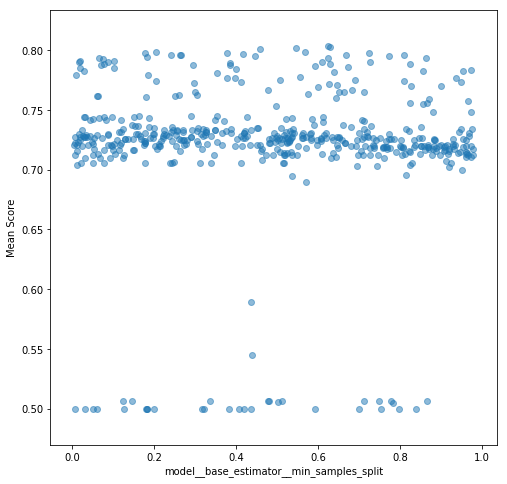

In [82]:
mean_score_scatter('model__n_estimators')

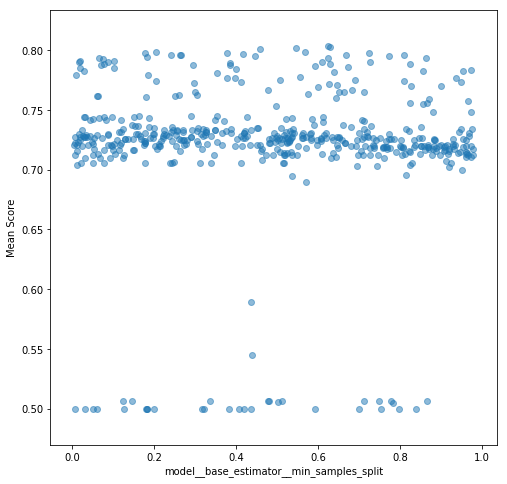

In [83]:
mean_score_scatter('model__base_estimator__max_depth')

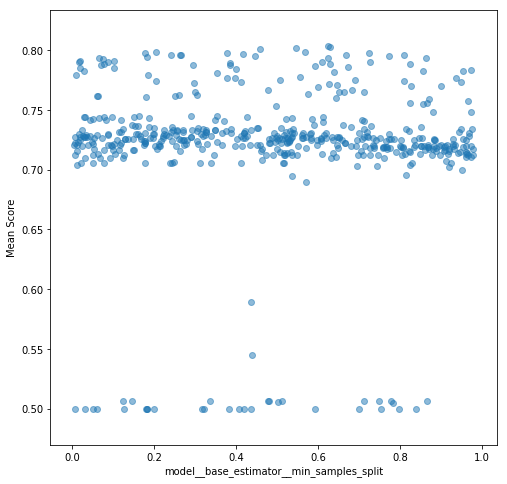

In [84]:
mean_score_scatter('model__base_estimator__max_features')

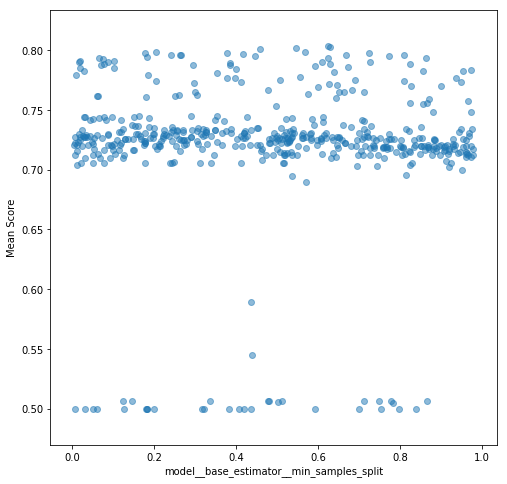

In [85]:
mean_score_scatter('model__base_estimator__min_samples_leaf')

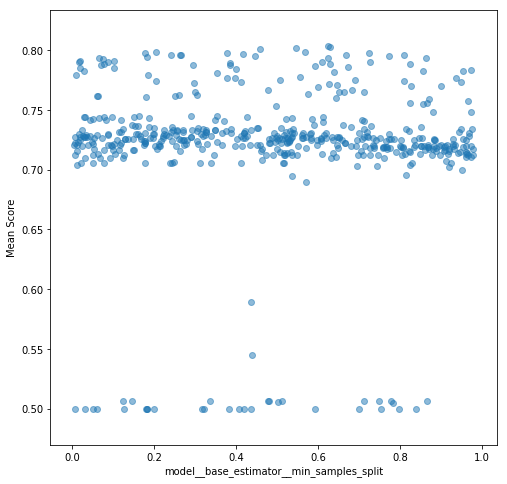

In [86]:
mean_score_scatter('model__base_estimator__min_samples_split')

In [56]:
# rescale the results so that we get more of a range in colors and sizes
rescaled_means = MinMaxScaler(feature_range=(100, 1000)).fit_transform(results_df['mean_score'].values.reshape(-1, 1))
rescaled_means = rescaled_means.flatten()  # reshape back to array

In [57]:
def compare_two_parameters(x_label, y_label):
    x = results_df[x_label]
    y = results_df[y_label]
    plt.scatter(x,y,c=rescaled_means, s=rescaled_means, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index_of_best = np.argmax(rescaled_means)
    plt.scatter(x[index_of_best], y[index_of_best], marker= 'x', s=200, color='red')
    fig = plt.gcf()
    fig.set_size_inches(15, 15)

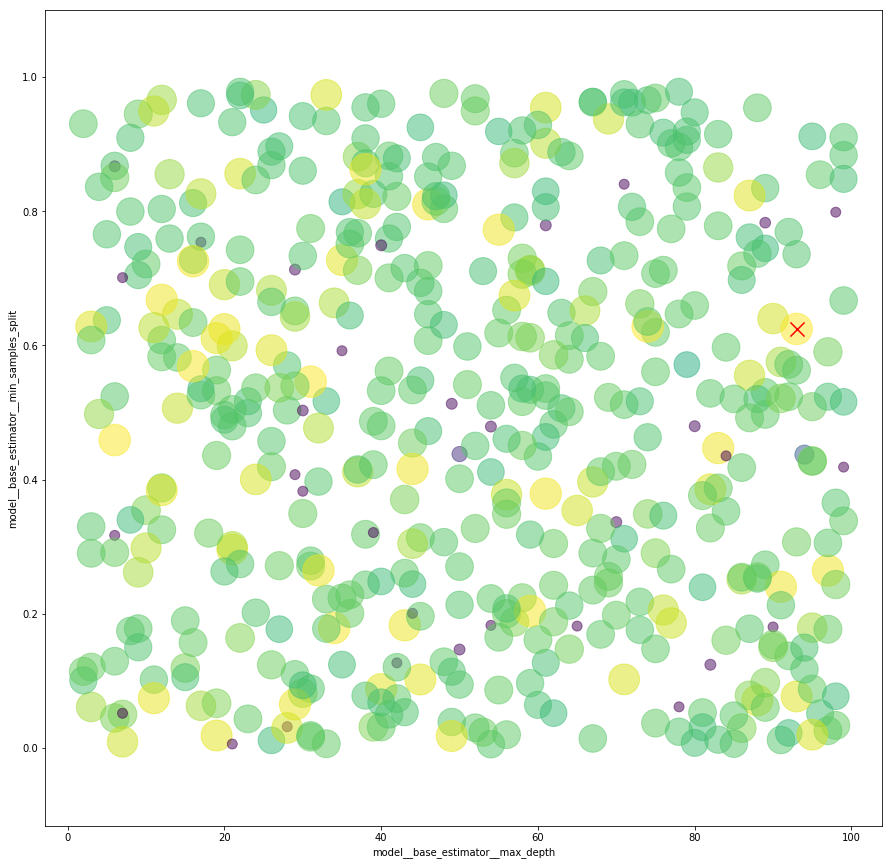

In [58]:
x_label = 'model__base_estimator__max_depth'
y_label = 'model__base_estimator__min_samples_split'
compare_two_parameters(x_label, y_label)

In [59]:
grid_search.best_score_, grid_search.best_params_

(0.8033240094599294,
 {'model__base_estimator__max_depth': 93,
  'model__base_estimator__max_features': 0.8487466432146791,
  'model__base_estimator__min_samples_leaf': 0.001766901543821723,
  'model__base_estimator__min_samples_split': 0.6246733427797388,
  'model__n_estimators': 1466,
  'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': False,
  'preparation__cap_gain_loss_pipeline__custom_transform__base': None,
  'preparation__num_pipeline__combine_agehours__combine': True})

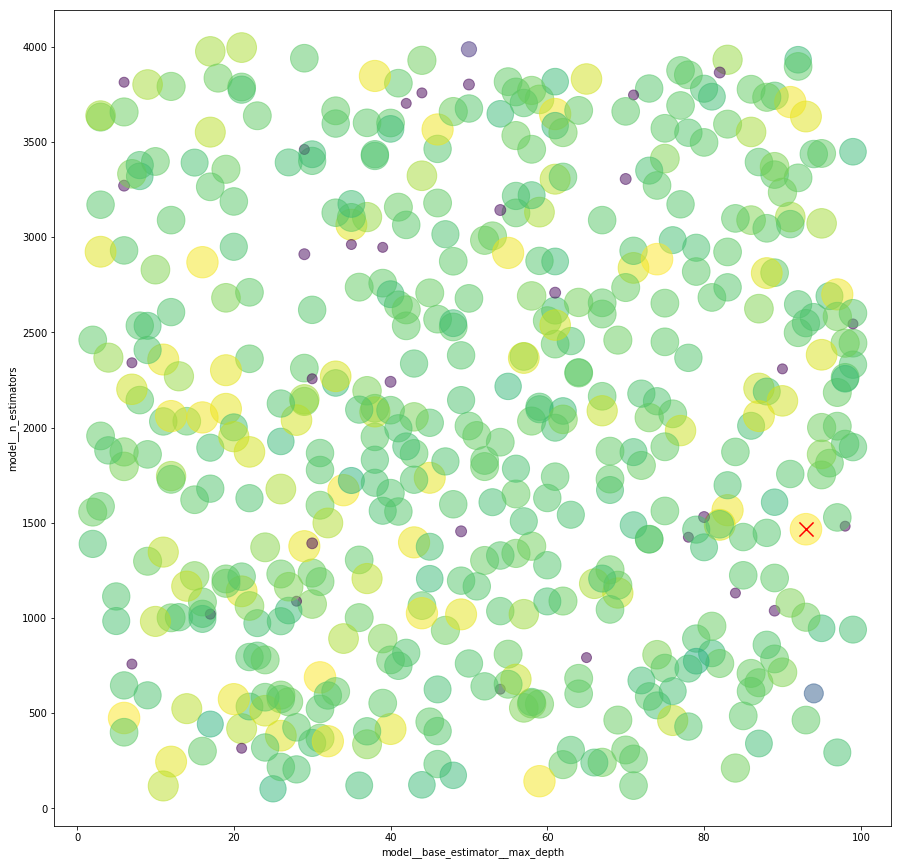

In [60]:
x_label = 'model__base_estimator__max_depth'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [61]:
grid_search.best_score_, grid_search.best_params_

(0.8033240094599294,
 {'model__base_estimator__max_depth': 93,
  'model__base_estimator__max_features': 0.8487466432146791,
  'model__base_estimator__min_samples_leaf': 0.001766901543821723,
  'model__base_estimator__min_samples_split': 0.6246733427797388,
  'model__n_estimators': 1466,
  'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': False,
  'preparation__cap_gain_loss_pipeline__custom_transform__base': None,
  'preparation__num_pipeline__combine_agehours__combine': True})

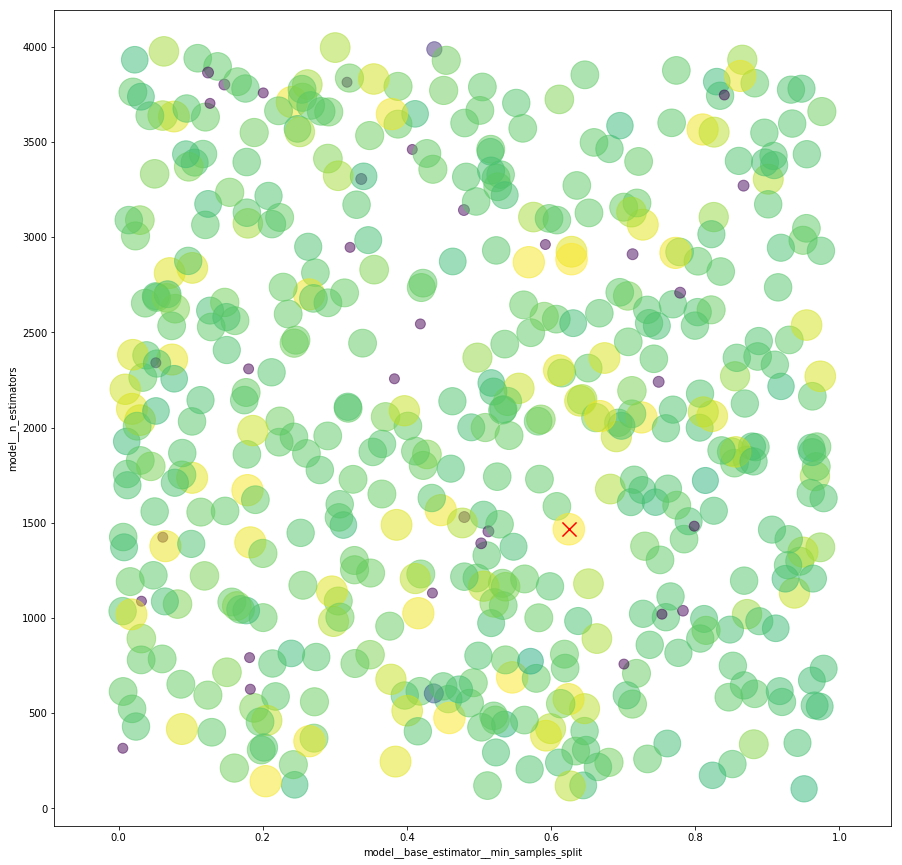

In [62]:
x_label = 'model__base_estimator__min_samples_split'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [63]:
grid_search.best_score_, grid_search.best_params_

(0.8033240094599294,
 {'model__base_estimator__max_depth': 93,
  'model__base_estimator__max_features': 0.8487466432146791,
  'model__base_estimator__min_samples_leaf': 0.001766901543821723,
  'model__base_estimator__min_samples_split': 0.6246733427797388,
  'model__n_estimators': 1466,
  'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': False,
  'preparation__cap_gain_loss_pipeline__custom_transform__base': None,
  'preparation__num_pipeline__combine_agehours__combine': True})

reference:

```
N = 1000
r = range(0, N)
x = r
y = r
colors = r
area = r

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()
```

In [64]:
# column order is based off of the pipeline and FeatureUnion
    # cap_gain_loss_pipeline
    # num_pipeline
    # cat_pipeline
features = ['capital-gain', 'capital-loss'] + ['Net Capital'] + ['age', 'education-num', 'hours-per-week'] + ['GDP Per Capita'] + one_hot_transformer.encoded_columns
importances = grid_search.best_estimator_.steps[1][1].feature_importances_

In [65]:
import pandas as pd
pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by=['importance'], ascending=False).head(20)

feature  importance
5   hours-per-week                     0.278056  
2   Net Capital                        0.111735  
1   capital-loss                       0.085920  
32  marital-status_Married-civ-spouse  0.073466  
4   education-num                      0.062959  
0   capital-gain                       0.060848  
3   age                                0.037488  
34  marital-status_Never-married       0.025498  
6   GDP Per Capita                     0.020376  
59  race_Black                         0.018349  
52  relationship_Not-in-family         0.013548  
30  marital-status_Divorced            0.011856  
47  occupation_Protective-serv         0.011443  
56  relationship_Wife                  0.010472  
55  relationship_Unmarried             0.010244  
11  workclass_Self-emp-not-inc         0.009867  
46  occupation_Prof-specialty          0.009791  
53  relationship_Other-relative        0.009754  
23  education_level_Bachelors          0.009648  
44  occupation_Other-service           0.007464